#  Entrega Final NBA Salaries

### Integrantes:

- Nicolas Biojo &ensp; A00137580 sis
- Cristian Cobo &ensp;A00348619 sis
- David Erazo &emsp; A00130528 sis   

# Análisis de calidad de los datos

En una primera instancia, se cargaron en un dataframe de pandas el dataset que contiene estadisticas avanzadas del rendiemiento de los jugadores de la NBS durante la temporada 2017-2018. 

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors, datasets, metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import decomposition
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering

In [2]:
data = pd.read_csv('2017-18_NBA_salary.csv')

In [3]:
data.head()

,Player,Salary,NBA_Country,NBA_DraftNumber,Age,Tm,G,MP,PER,TS%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Zhou Qi,815615,China,43,22,HOU,16,87,0.6,0.303,...,18.2,19.5,-0.4,0.1,-0.2,-0.121,-10.6,0.5,-10.1,-0.2
1,Zaza Pachulia,3477600,Georgia,42,33,GSW,66,937,16.8,0.608,...,19.3,17.2,1.7,1.4,3.1,0.160,-0.6,1.3,0.8,0.7
2,Zach Randolph,12307692,USA,19,36,SAC,59,1508,17.3,0.529,...,12.5,27.6,0.3,1.1,1.4,0.046,-0.6,-1.3,-1.9,0.0
3,Zach LaVine,3202217,USA,13,22,CHI,24,656,14.6,0.499,...,9.7,29.5,-0.1,0.5,0.4,0.027,-0.7,-2.0,-2.6,-0.1
4,Zach Collins,3057240,USA,10,20,POR,62,979,8.2,0.487,...,15.6,15.5,-0.4,1.2,0.8,0.038,-3.7,0.9,-2.9,-0.2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 28 columns):
Player             485 non-null object
Salary             485 non-null int64
NBA_Country        485 non-null object
NBA_DraftNumber    485 non-null int64
Age                485 non-null int64
Tm                 485 non-null object
G                  485 non-null int64
MP                 485 non-null int64
PER                485 non-null float64
TS%                483 non-null float64
3PAr               483 non-null float64
FTr                483 non-null float64
ORB%               485 non-null float64
DRB%               485 non-null float64
TRB%               485 non-null float64
AST%               485 non-null float64
STL%               485 non-null float64
BLK%               485 non-null float64
TOV%               483 non-null float64
USG%               485 non-null float64
OWS                485 non-null float64
DWS                485 non-null float64
WS                 485 non-n

Previo al análisis, se identificaron las variables cuantitativas y categoricas apartir del método .info(). Adicionalmente, este método nos permitió evidenciar la existencia de missing values a partir del número de registros por variable, los cuales fueron: TS%, 3PAr, FTr y TOV% en los registros 29 y 37.

### Búsqueda de valores nulos

In [5]:
mColums = pd.isnull(data).any(0).to_numpy().nonzero()[0]
print("Missing values: ")
for col in mColums:
    print ("  index {} name {}".format(col,data.columns[col]))

Missing values: 
  index 9 name TS%
  index 10 name 3PAr
  index 11 name FTr
  index 18 name TOV%


In [6]:
index = pd.isnull(data).any(1).to_numpy().nonzero()[0]
print("{} incomplete records:".format(len(index)), index)

2 incomplete records: [29 37]


In [7]:
originalData = data.copy()
data = data.dropna()
print("Datos originales: ", originalData.shape)
print("Datos limpios y completos: ", data.shape)
print("Se eliminaron {} registos".format(originalData.shape[0] - data.shape[0]))

Datos originales:  (485, 28)
Datos limpios y completos:  (483, 28)
Se eliminaron 2 registos


### Análisis de variables relevantes

Acontinuación, se lleva acabo un análisis sobre las variables de mayor relevancia para identificar inconsistencias o datos erronoes. 

- Player: Podemos ver que existen jugadores en varios equipos. En este caso el jugador Kay Felder se encuentra en los equipos: DET,CHI y TOT.
- NBA_Country: No existen dos o más labels distintos para representar un mismo país.
- Age: No existe ningun jugador el cual sea menor de 18 años.
- Salary: Todos los pagos a los jugadores son valores positivos.
- TS%: Se logra identificar un posible dato erroneo el cual determina un 150%. 
- G: Todas las cantidades de partidos jugados son valores positivos.
- MP: Todos los valores referentes a los minutos jugados son valores positivos.
- OWS: Los valores referentes al número estimado de victorias por un desempeño ofensivo presenta valores positivos como                negativos, donde suponemos que los negativos representan las derrotas. 
- DWS: Los valores referentes al número estimado de victorias por un desempeño defensivo presenta valores positivos
- WS: Los valores referentes al número estimado de victorias contribuidas por un jugador, presenta valores positivos como             negativos, donde suponemos que los negativos representan las derrotas. 

Busqueda de jugadores en más de un equipo 

In [8]:
data.describe()

,Salary,NBA_DraftNumber,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,4.830000e+02,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,...,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,6.660622e+06,29.395445,26.273292,50.370600,1158.915114,13.315735,0.535387,0.337383,0.263404,4.893996,...,13.140373,18.975569,1.280745,1.181366,2.465424,0.080325,-1.252588,-0.489441,-1.741822,0.601242
std,7.398214e+06,21.116033,4.274290,24.723561,809.627553,8.745666,0.112352,0.226894,0.294578,4.581519,...,6.115290,5.826533,1.883545,1.033939,2.674520,0.163229,5.028752,2.394156,5.665905,1.247636
min,4.608000e+04,1.000000,19.000000,1.000000,1.000000,-41.100000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.700000,-2.300000,0.000000,-1.200000,-1.063000,-36.500000,-14.300000,-49.200000,-1.300000
25%,1.471382e+06,10.500000,23.000000,29.500000,385.000000,9.800000,0.505500,0.167000,0.155000,1.800000,...,9.900000,15.000000,0.000000,0.300000,0.300000,0.040500,-2.600000,-1.700000,-3.500000,-0.100000
50%,3.218280e+06,25.000000,26.000000,59.000000,1151.000000,13.200000,0.545000,0.346000,0.231000,3.300000,...,12.500000,17.900000,0.800000,1.000000,1.900000,0.083000,-1.100000,-0.400000,-1.300000,0.100000
75%,1.000000e+07,47.000000,29.000000,71.000000,1824.500000,16.550000,0.582500,0.481000,0.319500,7.050000,...,15.750000,22.250000,2.000000,1.800000,3.600000,0.123000,0.400000,1.000000,0.550000,0.900000
max,3.468255e+07,62.000000,41.000000,79.000000,2898.000000,134.100000,1.500000,1.000000,5.333000,35.900000,...,66.700000,45.100000,11.400000,5.600000,15.000000,2.713000,68.700000,6.800000,54.400000,8.600000


In [9]:
data["NBA_Country"].unique()

array(['China', 'Georgia', 'USA', 'Canada', 'Spain', 'France',
       'Czech Republic', 'Russia', 'South Sudan', 'Switzerland',
       'New Zealand', 'Haiti', 'Democratic Re_', 'Tunisia', 'Brazil',
       'Germany', 'Australia', 'Cameroon', 'Israel', 'Turkey',
       'United Kingdo...', 'Montenegro', 'Serbia', 'Argentina', 'Bosnia',
       'Lithuania', 'Croatia', 'Italy', 'Poland', 'Dominican Rep...',
       'Finland', 'Latvia', 'Bosnia & Herz...', 'Sweden', 'Ukraine',
       'Austria', 'Puerto Rico', 'Senegal', 'Slovenia', 'Greece',
       'Democratic Re...', 'Mali', 'Bahamas', 'Egypt'], dtype=object)

In [10]:
print ("Menores de edad: {}".format(data.loc[data.Age < 18].shape[0]))

Menores de edad: 0


In [11]:
playersNba = data.iloc[:,0]
boolPlayersDuplicated = playersNba.duplicated()

i = 0
for x in boolPlayersDuplicated: 
    i +=1
    if(x == True):
        print(data.iloc[lambda m: m.index  == i].Player)
   


224    Kay Felder
Name: Player, dtype: object
225    Kay Felder
Name: Player, dtype: object


# Visualización de datos

En la siguiente matriz de correlación podemos identificar las relaciones entre todas las variables, donde los slots más claros representan un valor porcentaul de relación más alto. Mientras que los slots más oscuros representan una relación inversamente proporcional entre las variables. 


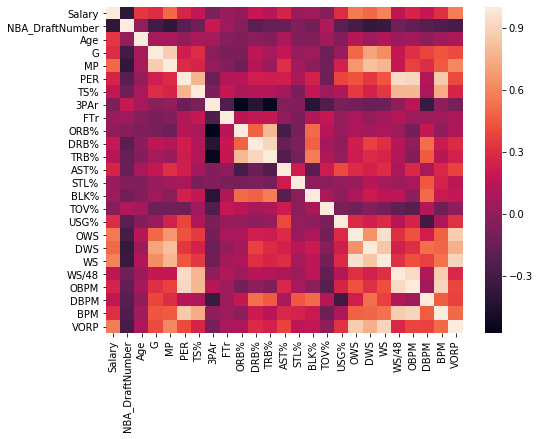

<Figure size 7200x4320 with 0 Axes>

In [12]:
fig = plt.figure(figsize=(8,6))
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=False)
plt.figure(figsize=(100,60))
plt.show()

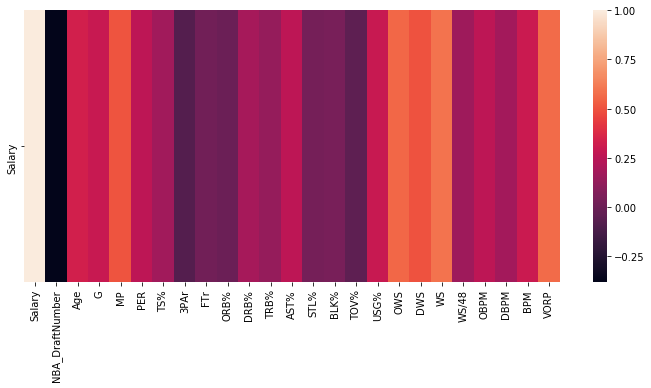

In [13]:
fig = plt.figure(figsize=(12,5))
sn.heatmap(corrMatrix[:1], annot=False)
plt.show()

Para evaluar la relación entre el salario de los jugadores y el resto de variables, realizamos la siguiente matriz de correlación, la cual nos permitio identificar las variables que están más relacionadas con esta:


- MP: Minutos jugados

- OWS: Offensive Win Shares (número estimado de victorias contribuidas por un jugador dado su desempeño ofensivo)

- DWS: Defensive Win Shares (número estimado de victorias contribuidas por un jugador dado su desempeño defensivo)

- WS: Win Shares (número estimado de victorias contribuidas por un jugador)

- VORP: Value Over Replacement Player (métrica para medir la contribución total de un jugador al equipo)



### Análsis diagrama de Cajas y Bigotes

A continuación, por cada una de las variables que seleccionamos, las representamos por medio de diagramas de caja para poder observar la distribución de cada una de estas. 

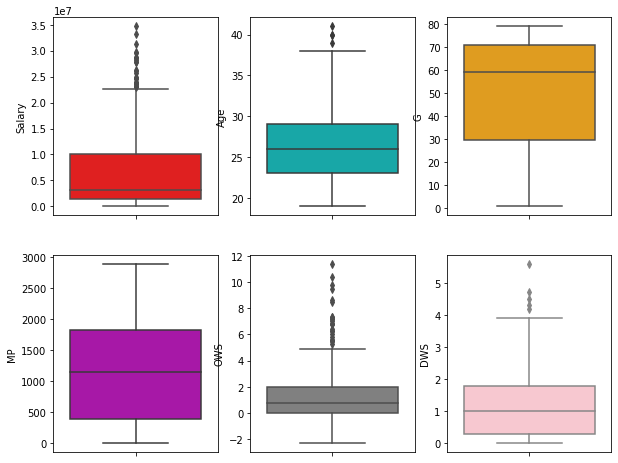

In [14]:
fig = plt.figure(figsize=(10,8))

plt.subplot(2,3,1)
sn.boxplot('Salary', data=data, orient='v', color="r")

plt.subplot(2,3,2)
sn.boxplot('Age', data=data, orient='v', color="c")

plt.subplot(2,3,3)
sn.boxplot('G', data=data, orient='v', color="orange")

plt.subplot(2,3,4)
sn.boxplot('MP', data=data, orient='v', color="m")

plt.subplot(2,3,5)
sn.boxplot('OWS', data=data, orient='v', color="gray")

plt.subplot(2,3,6)
sn.boxplot('DWS', data=data, orient='v', color="pink")

- Como se puede obsevar en el anterior diagrama de cajas y bigotes de la variable "Salary" al menos el 50% de los jugadores gana en promedio entre 0.25 y 0.3 millones de dolares.

- En cuanto se refiere a la variable "Age" se puede afirmar que, al menos el 50% de los jugadores tienen una edad entre 26 y 27 años. Además tambien se puede decir que al menos el 75% de los jugadores tienen una edad menor a 30 años. 

- Si observamos el diagrama de cajas de la variable "G"(No. de partidos jugados) podemos ver que al menos el 50% de los jugadores de la temporada NBA 2017-2018 jugaron aproxidamente 60 partidos. Y al menos el 25% de estos jugadores tuvieron aproximadamente el 30 partidos. 

- Ahora bien, si analizamos el grafico de la variable "MP"(Minutos jugados) podemos ver que este particular se diferencia de los demás puesto a aque su sesgo tiende a ser simétrico. Tambien se puede decir que al menos el 50% de los jugadores de la temporada 18-17 de la NBA  ha jugado aproximadamente 1200 minutos. Y al menos el 75% ha jugado entre 1800 y 1900 minutos.

- En el diagrama de cajas de la variable "OWS" (Número estimado de victorias contribuidas por un jugador dado su desempeño ofensivo) se puede ver que existe una gran cantidad de datos atípicos. Estos puntos atípicos representan alto número de vitorias dado al buen desempeño ofensivo de ese jugador. 

- El diagrama de caja de la variable "DWS" al igual que lz variable "OWS" tambien tiende a tener sesgo negativo. Y al menos el 50% de los jugadores cuentan con un puntaje de 1 para esta variable.







### Análisis de Histogramas 

Distribuciones: Salary, Age y Mp(Minutos jugados)

Text(0.5, 1.0, 'MP')

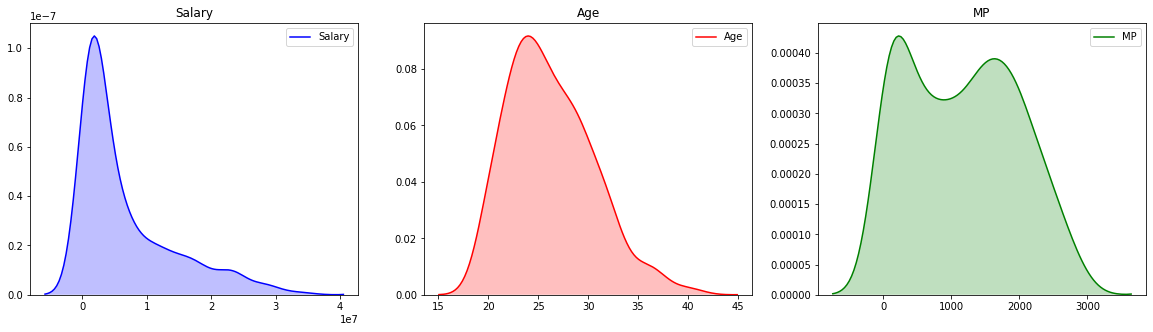

In [15]:
fig = plt.figure(figsize=(20,5))

d = data.iloc[:,1]
plt.subplot(1,3,1)
ax = sn.kdeplot(d, shade=True, color="b")
ax.set_title("Salary")

d = data.iloc[:,4]
plt.subplot(1,3,2)
ax = sn.kdeplot(d, shade=True, color="r")
ax.set_title("Age")

d = data.iloc[:,7]
plt.subplot(1,3,3)
ax = sn.kdeplot(d, shade=True, color="g")
ax.set_title("MP")


- Gráfico 1: La variable "Salary" tiende a tener una distribución Chi - Cuadrada
- Gráfico 2: La variable "Age" tiende a tener una distribución Normal
- Gráfico 3: La varivale "Mp" (Minutos jugados) tiende a tener una distribución Bimodal. 

# Limpieza de datos

La limpieza de datos es un proceso necesario para asegurar la calidad de los datos. Este paso es muy importante para minimizar el error al basarnos en información poco precisa, errónea o incompleta.

In [16]:
data.dtypes

Player              object
Salary               int64
NBA_Country         object
NBA_DraftNumber      int64
Age                  int64
Tm                  object
G                    int64
MP                   int64
PER                float64
TS%                float64
3PAr               float64
FTr                float64
ORB%               float64
DRB%               float64
TRB%               float64
AST%               float64
STL%               float64
BLK%               float64
TOV%               float64
USG%               float64
OWS                float64
DWS                float64
WS                 float64
WS/48              float64
OBPM               float64
DBPM               float64
BPM                float64
VORP               float64
dtype: object

In [17]:
data['Player']=data['Player'].astype('category')
data['NBA_Country']=data['NBA_Country'].astype('category')
data['Tm']=data['Tm'].astype('category')
data.dtypes

Player             category
Salary                int64
NBA_Country        category
NBA_DraftNumber       int64
Age                   int64
Tm                 category
G                     int64
MP                    int64
PER                 float64
TS%                 float64
3PAr                float64
FTr                 float64
ORB%                float64
DRB%                float64
TRB%                float64
AST%                float64
STL%                float64
BLK%                float64
TOV%                float64
USG%                float64
OWS                 float64
DWS                 float64
WS                  float64
WS/48               float64
OBPM                float64
DBPM                float64
BPM                 float64
VORP                float64
dtype: object

Para las variables Player, NBA_Country y Tm se les modificó el tipo de variable object a categorica, ya que esto facilita la ejecución de los modelos.

In [18]:
numHeaders = ['Salary', 'NBA_DraftNumber', 'Age','G','MP', 'PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','OBPM','DBPM','BPM','VORP']
print("Datos antes de eliminar valores atípicos: ", data.shape)

for header in numHeaders:
    print("Valores atípicos de la variable "+header+":",len(data[abs(data[header])>(data[header].mean()+(data[header].std()*4))]))
    data.drop(data[abs(data[header])>(data[header].mean()+(data[header].std()*6))].index,inplace=True)
print("Datos despúes de eliminar valores atípicos: ", data.shape)
    

Datos antes de eliminar valores atípicos:  (483, 28)
Valores atípicos de la variable Salary: 0
Valores atípicos de la variable NBA_DraftNumber: 0
Valores atípicos de la variable Age: 0
Valores atípicos de la variable G: 0
Valores atípicos de la variable MP: 0
Valores atípicos de la variable PER: 1
Valores atípicos de la variable TS%: 1
Valores atípicos de la variable 3PAr: 0
Valores atípicos de la variable FTr: 3
Valores atípicos de la variable ORB%: 3
Valores atípicos de la variable DRB%: 0
Valores atípicos de la variable TRB%: 0
Valores atípicos de la variable AST%: 1
Valores atípicos de la variable STL%: 4
Valores atípicos de la variable BLK%: 2
Valores atípicos de la variable TOV%: 4
Valores atípicos de la variable USG%: 1
Valores atípicos de la variable OWS: 4
Valores atípicos de la variable DWS: 1
Valores atípicos de la variable WS: 2
Valores atípicos de la variable OBPM: 4
Valores atípicos de la variable DBPM: 4
Valores atípicos de la variable BPM: 5
Valores atípicos de la varia

Para eliminar los datos atípicos se optó por hacer una limpieza general teniendo en cuenta las desviaciones estandar de cada variable, eliminando los datos que estuvieran por fuera de 6 desviaciones estandar. El motivo por el cual se escogio 6 desviaciones estandar fue para reducir la cantidad de datos a eliminar y así no perjudicar el entendimiento de los mismos, obteniendo como resultado la eliminación de 9 registros. 

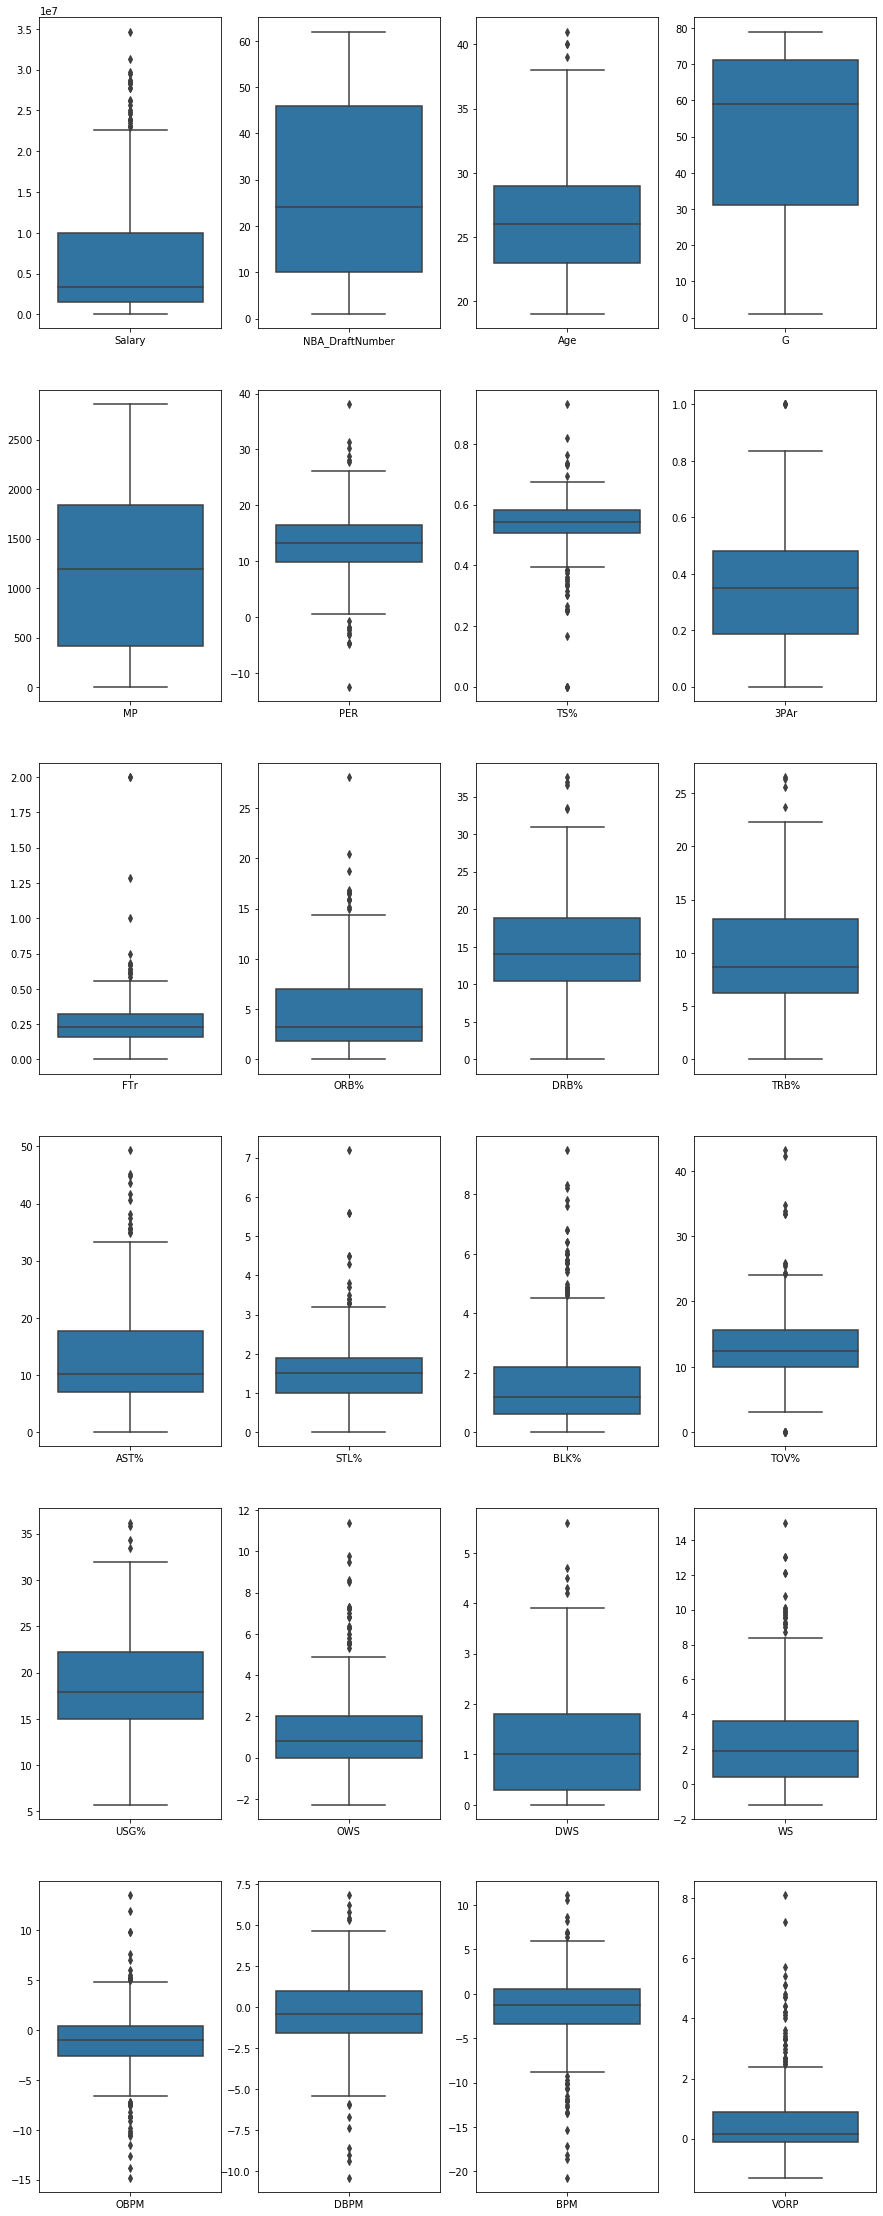

In [19]:
fig = plt.figure(figsize=(15,40))

plt.subplot(6,4,1);  sn.boxplot( orient= "v", data=data[['Salary']])
plt.subplot(6,4,2);  sn.boxplot( orient= "v", data=data[['NBA_DraftNumber']])
plt.subplot(6,4,3);  sn.boxplot( orient= "v", data=data[['Age']])
plt.subplot(6,4,4);  sn.boxplot( orient= "v", data=data[['G']])
plt.subplot(6,4,5);  sn.boxplot( orient= "v", data=data[['MP']])
plt.subplot(6,4,6);  sn.boxplot( orient= "v", data=data[['PER']])
plt.subplot(6,4,7);  sn.boxplot( orient= "v", data=data[['TS%']])
plt.subplot(6,4,8);  sn.boxplot( orient= "v", data=data[['3PAr']])
plt.subplot(6,4,9);  sn.boxplot( orient= "v", data=data[['FTr']])
plt.subplot(6,4,10); sn.boxplot( orient= "v", data=data[['ORB%']])
plt.subplot(6,4,11); sn.boxplot( orient= "v", data=data[['DRB%']])
plt.subplot(6,4,12); sn.boxplot( orient= "v", data=data[['TRB%']])
plt.subplot(6,4,13); sn.boxplot( orient= "v", data=data[['AST%']])
plt.subplot(6,4,14); sn.boxplot( orient= "v", data=data[['STL%']])
plt.subplot(6,4,15); sn.boxplot( orient= "v", data=data[['BLK%']])
plt.subplot(6,4,16); sn.boxplot( orient= "v", data=data[['TOV%']])
plt.subplot(6,4,17); sn.boxplot( orient= "v", data=data[['USG%']])
plt.subplot(6,4,18); sn.boxplot( orient= "v", data=data[['OWS']])
plt.subplot(6,4,19); sn.boxplot( orient= "v", data=data[['DWS']])
plt.subplot(6,4,20); sn.boxplot( orient= "v", data=data[['WS']])
plt.subplot(6,4,21); sn.boxplot( orient= "v", data=data[['OBPM']])
plt.subplot(6,4,22); sn.boxplot( orient= "v", data=data[['DBPM']])
plt.subplot(6,4,23); sn.boxplot( orient= "v", data=data[['BPM']])
plt.subplot(6,4,24); sn.boxplot( orient= "v", data=data[['VORP']])

In [20]:
index_names = data[ (data['PER'] > 38) | (data['PER'] < -10)].index   
data.drop(index_names, inplace = True)
print(data.shape)

(472, 28)


In [21]:
index_names = data[(data['TS%'] > 0.90)].index   
data.drop(index_names, inplace = True)
print(data.shape)

(471, 28)


In [22]:
index_names = data[(data['FTr'] > 0.8)].index   
data.drop(index_names, inplace = True)
print(data.shape)

(468, 28)


In [23]:
index_names = data[(data['ORB%'] > 25)].index   
data.drop(index_names, inplace = True)
print(data.shape)

(467, 28)


In [24]:
index_names = data[(data['STL%'] > 6)].index   
data.drop(index_names, inplace = True)
print(data.shape)

(466, 28)


In [25]:
index_names = data[(data['OWS'] > 11)].index   
data.drop(index_names, inplace = True)
print(data.shape)

(465, 28)


En una segunda instancia, se llevo acabo un análsis detallado sobre los datos de cada una de las variables por medio de diagramas de caja, en donde nos permitió identificar datos que seguian siendo atípicos. Los siguientes diagramas de caja muestarn los datos despues de la limpieza.

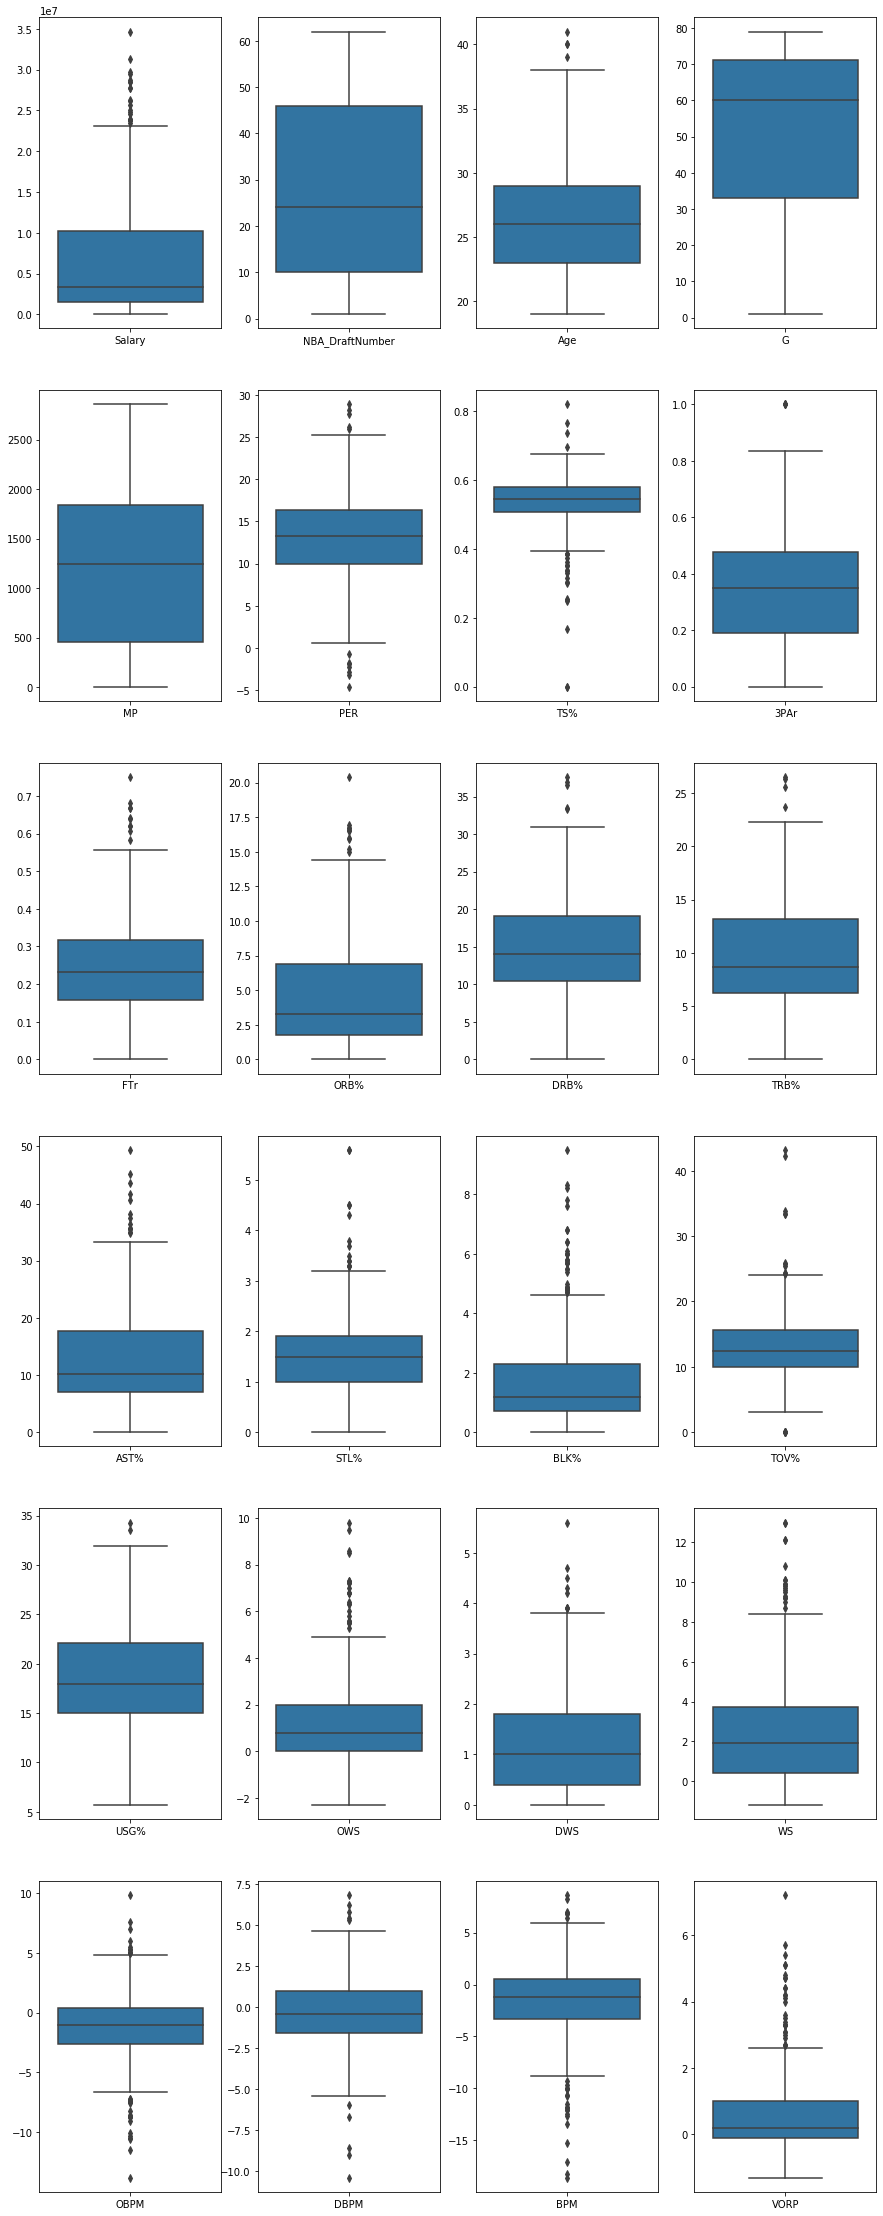

In [26]:
fig = plt.figure(figsize=(15,40))

plt.subplot(6,4,1);  sn.boxplot( orient= "v", data=data[['Salary']])
plt.subplot(6,4,2);  sn.boxplot( orient= "v", data=data[['NBA_DraftNumber']])
plt.subplot(6,4,3);  sn.boxplot( orient= "v", data=data[['Age']])
plt.subplot(6,4,4);  sn.boxplot( orient= "v", data=data[['G']])
plt.subplot(6,4,5);  sn.boxplot( orient= "v", data=data[['MP']])
plt.subplot(6,4,6);  sn.boxplot( orient= "v", data=data[['PER']])
plt.subplot(6,4,7);  sn.boxplot( orient= "v", data=data[['TS%']])
plt.subplot(6,4,8);  sn.boxplot( orient= "v", data=data[['3PAr']])
plt.subplot(6,4,9);  sn.boxplot( orient= "v", data=data[['FTr']])
plt.subplot(6,4,10); sn.boxplot( orient= "v", data=data[['ORB%']])
plt.subplot(6,4,11); sn.boxplot( orient= "v", data=data[['DRB%']])
plt.subplot(6,4,12); sn.boxplot( orient= "v", data=data[['TRB%']])
plt.subplot(6,4,13); sn.boxplot( orient= "v", data=data[['AST%']])
plt.subplot(6,4,14); sn.boxplot( orient= "v", data=data[['STL%']])
plt.subplot(6,4,15); sn.boxplot( orient= "v", data=data[['BLK%']])
plt.subplot(6,4,16); sn.boxplot( orient= "v", data=data[['TOV%']])
plt.subplot(6,4,17); sn.boxplot( orient= "v", data=data[['USG%']])
plt.subplot(6,4,18); sn.boxplot( orient= "v", data=data[['OWS']])
plt.subplot(6,4,19); sn.boxplot( orient= "v", data=data[['DWS']])
plt.subplot(6,4,20); sn.boxplot( orient= "v", data=data[['WS']])
plt.subplot(6,4,21); sn.boxplot( orient= "v", data=data[['OBPM']])
plt.subplot(6,4,22); sn.boxplot( orient= "v", data=data[['DBPM']])
plt.subplot(6,4,23); sn.boxplot( orient= "v", data=data[['BPM']])
plt.subplot(6,4,24); sn.boxplot( orient= "v", data=data[['VORP']])

# Normalización de datos

In [27]:
stdsc = StandardScaler()
x = data[numHeaders].values
x_scaled = stdsc.fit_transform(x)
data_t = pd.DataFrame(x_scaled, columns=numHeaders, index=data.index)
dataN = data.copy()
dataN[numHeaders] = data_t

In [28]:
dataN.mean()

Salary             1.360919e-17
NBA_DraftNumber    5.389954e-17
Age               -2.191795e-16
G                 -2.220446e-17
MP                -4.154383e-17
PER               -6.995599e-17
TS%               -3.695968e-16
3PAr               3.843998e-17
FTr                1.384794e-17
ORB%               1.146037e-17
DRB%              -1.165137e-16
TRB%               1.351368e-16
AST%               4.978097e-17
STL%              -3.479893e-17
BLK%              -1.117386e-16
TOV%               9.806970e-17
USG%              -7.479083e-17
OWS                6.303202e-17
DWS               -1.738156e-16
WS                -1.045758e-16
WS/48              8.026882e-02
OBPM              -8.356517e-18
DBPM               8.595275e-18
BPM               -1.072022e-16
VORP              -9.884566e-17
dtype: float64

In [29]:
dataN.std()

Salary             1.001077
NBA_DraftNumber    1.001077
Age                1.001077
G                  1.001077
MP                 1.001077
PER                1.001077
TS%                1.001077
3PAr               1.001077
FTr                1.001077
ORB%               1.001077
DRB%               1.001077
TRB%               1.001077
AST%               1.001077
STL%               1.001077
BLK%               1.001077
TOV%               1.001077
USG%               1.001077
OWS                1.001077
DWS                1.001077
WS                 1.001077
WS/48              0.073925
OBPM               1.001077
DBPM               1.001077
BPM                1.001077
VORP               1.001077
dtype: float64

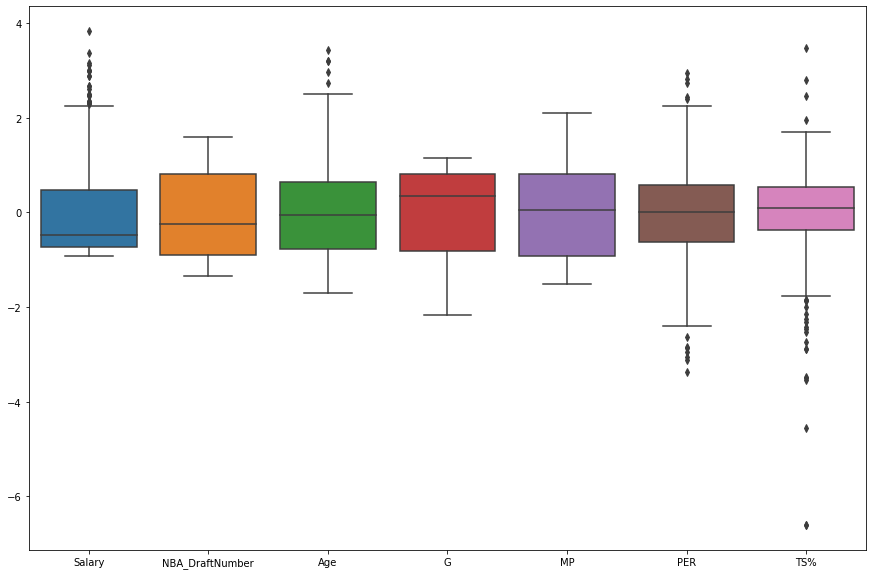

In [30]:
plt.rc('figure',figsize=(15,10))
sn.boxplot( orient= "v", data=dataN[numHeaders[0:7]])

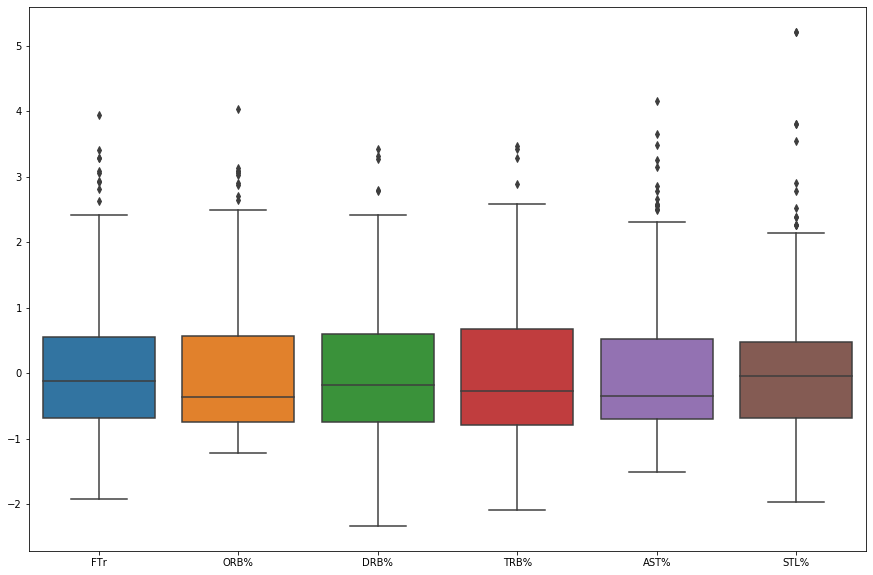

In [31]:
sn.boxplot( orient= "v", data=dataN[numHeaders[8:14]])

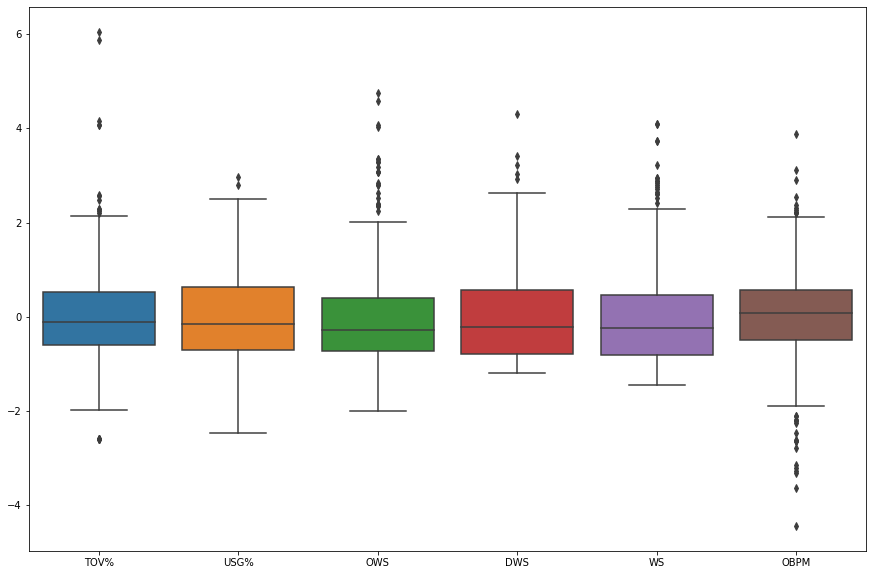

In [32]:
sn.boxplot( orient= "v", data=dataN[numHeaders[15:21]])

# Análisis para el modelamiento 

Text(0, 0.5, 'Rango')

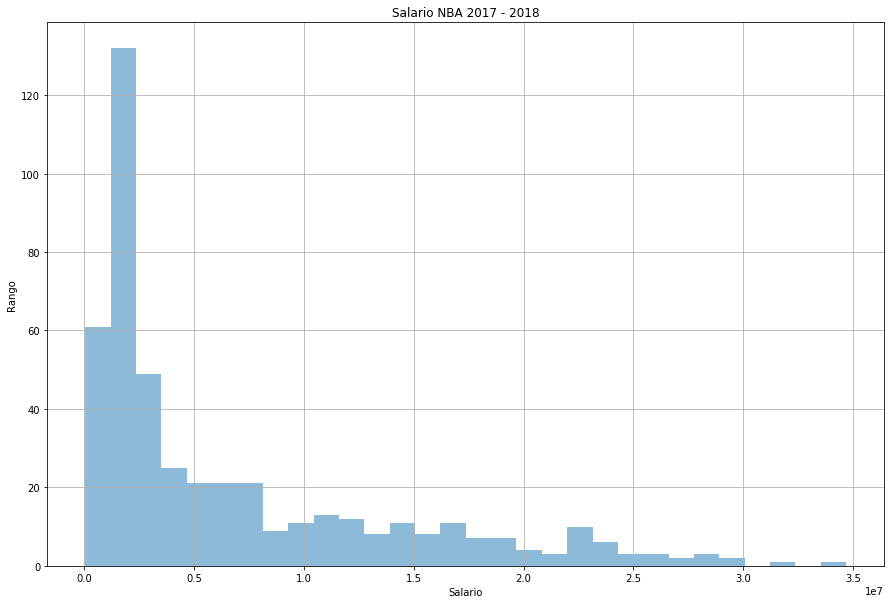

In [33]:
data.Salary.hist(bins=30, alpha=0.5)
plt.title("Salario NBA 2017 - 2018")
plt.xlabel("Salario")
plt.ylabel("Rango")

In [34]:
usaPlayers = data[data['NBA_Country'] == 'USA']
foreignPlayers = data[data['NBA_Country'] != 'USA']
print("El número de jugadores extranjeros de la NBA son: "+ str(foreignPlayers.Player.count()))

El número de jugadores extranjeros de la NBA son: 107


In [35]:
print("El número de jugadores de USA de la NBA son: "+ str( usaPlayers.Player.count()))

El número de jugadores de USA de la NBA son: 358


### Gráficas de densidad

La siguientes gráficas son de densidad de algunas variables que nos parecieron interesantes.  Estas  nos permiten visualizar la distribución de datos en un intervalo  continuo. Estás gráficas son una variación de  Histogramas que usa el suavizado de cerner para trazar valores, permitiendo distribuciones más suaves al suavizar el ruido. Los picos de un gráfico de densidad ayudan a mostrar dónde los valores se concentran en el intervalo.

Una ventaja de los gráficos de densidad sobre los histogramas es que son mejores para determinar la forma de distribución porque no se ven afectados por el número de contenedores utilizados (cada barra utilizada en un histograma típico). haría un histograma de 20 compartimientos. Sin embargo, con los gráficos de densidad esto no es un problema.

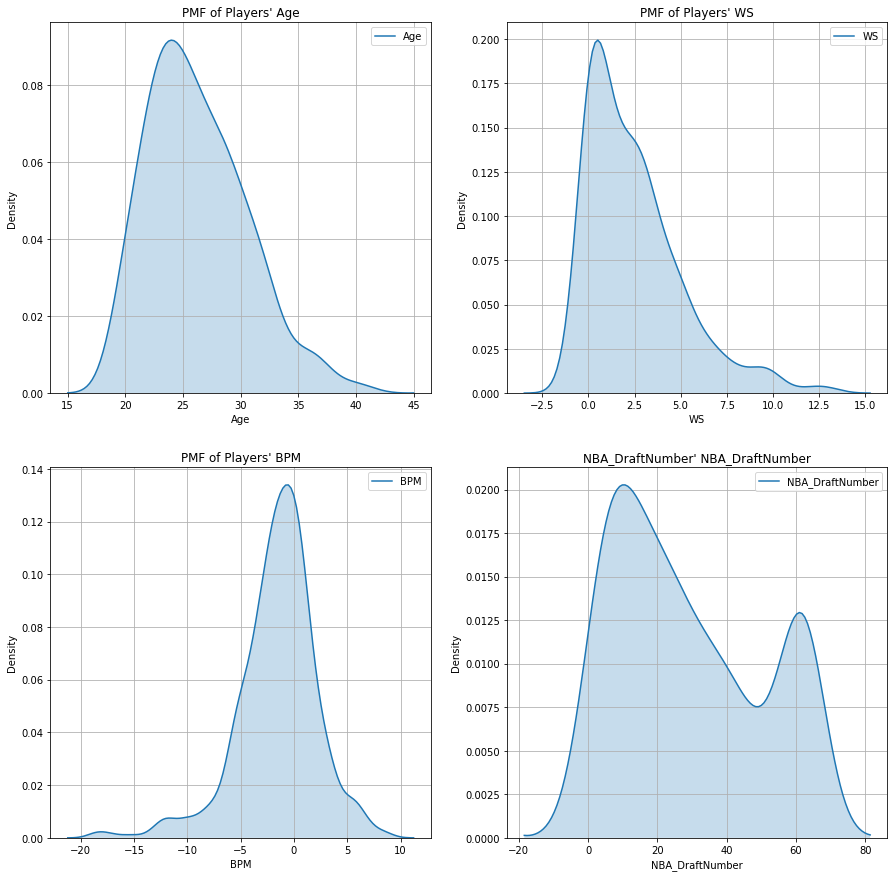

In [36]:
fig = plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
#plt.figure(figsize=(10,6))
sn.kdeplot(data.Age, shade=True)
plt.title("PMF of Players' Age")
plt.ylabel("Density")
plt.xlabel('Age')
plt.grid(True)
#plt.show()

plt.subplot(2,2,2)
#plt.figure(figsize=(10,6))
sn.kdeplot(data.WS, shade=True)
plt.title("PMF of Players' WS")
plt.ylabel("Density")
plt.xlabel('WS')
plt.grid(True)
#plt.show()

plt.subplot(2,2,3)
#plt.figure(figsize=(10,6))
sn.kdeplot(data.BPM, shade=True)
plt.title("PMF of Players' BPM")
plt.ylabel("Density")
plt.xlabel('BPM')
plt.grid(True)
#plt.show()

plt.subplot(2,2,4)
#plt.figure(figsize=(10,6))
sn.kdeplot(data.NBA_DraftNumber, shade=True)
plt.title("NBA_DraftNumber' NBA_DraftNumber")
plt.ylabel("Density")
plt.xlabel('NBA_DraftNumber')
plt.grid(True)
#plt.show()

# Selección de variables

In [37]:
y=data['Salary']
initial_list = ['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']
X=data[initial_list]

warnings.simplefilter(action='ignore', category=FutureWarning)

def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out = 0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

Add  WS                             with p-value 1.42032e-39
Add  Age                            with p-value 8.37161e-14
Add  NBA_DraftNumber                with p-value 5.8574e-09
Add  USG%                           with p-value 9.90294e-06
Add  G                              with p-value 0.000814904
Add  MP                             with p-value 7.80849e-10
Drop USG%                           with p-value 0.0836222
resulting features:
['WS', 'Age', 'NBA_DraftNumber', 'G', 'MP']


Selección de variables 
Dado a que el set de datos cuenta con 24 variables independientes para la predicción de la variable Salary nos encontramos con un gran volumen de regresores candidatos, sin embargo creemos que  la mayoría terminan no siendo útiles en el modelado de regresión. Es por eso que nos dimos la tarea de encontrar el conjunto de regresores más apropiado es una cuestión de selección de variables. Ahora bien, desafortunadamente, la selección de variables tiene dos objetivos en conflicto: (a) por un lado, tratamos de incluir tantos regresores como sea posible para que podamos maximizar el poder explicativo de nuestro modelo, (b) por otro lado, queremos tan pocos predictores como sea posible porque más regresores podrían conducir a una mayor variación en la predicción.

Al comenzar con un conjunto de características muy grande, eliminar algunas de ellas a menudo da como resultado un modelo con mayor precisión. Esto no es sorprendente porque cuando retenemos variables con coeficientes cero o coeficientes con valores menores que sus errores estándar, las estimaciones de los parámetros y la respuesta predicha aumentan de manera irrazonable. Sin embargo, eliminar variables también podría aumentar el sesgo en las estimaciones de los coeficientes y la respuesta. Afortunadamente, podemos encontrar un punto en el que la eliminación de variables tiene un pequeño impacto y el error (MSE) asociado con las estimaciones de los parámetros será menor que la reducción de la varianza.

Fordward step:

Implica comenzar sin variables en el modelo, probar la adición de cada variable utilizando un criterio de ajuste del modelo elegido, agregar la variable, en el caso que exista, cuya inclusión proporciona la mejora estadísticamente más significativa del ajuste, este proceso se repite hasta que ninguna variable mejore el modelo en un grado estadísticamente significativo.


Backward step:

Implica comenzar con todas las variables candidatas, probar la eliminación de cada variable utilizando un criterio de ajuste del modelo elegido, eliminar la variable, en el caso que existiera, cuya pérdida produce el deterioro más insignificante estadísticamente del ajuste del modelo, y repetir este proceso hasta que no se pueden eliminar más variables sin una pérdida de ajuste estadísticamente insignificante.


### Gráficas de regresión de las variables seleccionadas

Para el análisis de las variables que fueron seleccionadas por el anterior algoritmo vimos pertinente observar la relación que pudiese existir con la variable Salary. Es por esa razón que realizamos los siguientes gráficos dado a que la correlación lineal y la regresión lineal simple son métodos estadísticos que estudian la relación lineal existente entre dos variables (variables seleccionadas). Antes de profundizar en cada una de ellas, conviene destacar algunas diferencias:
La correlación cuantifica como de relacionadas están dos variables, mientras que la regresión lineal consiste en generar una ecuación (modelo) que, basándose en la relación existente entre ambas variables, permita predecir el valor de una a partir de la otra.
El cálculo de la correlación entre dos variables es independiente del orden o asignación de cada variable a 
Y, mide únicamente la relación entre ambas sin considerar dependencias. En el caso de la regresión lineal, el modelo varía según qué variable se considere dependiente de la otra (lo cual no implica causa-efecto).
A nivel experimental, la correlación se suele emplear cuando ninguna de las variables se ha controlado, simplemente se han medido ambas y se desea saber si están relacionadas. En el caso de estudios de regresión lineal, es más común que una de las variables se controle y se mida la otra.
Por norma general, los estudios de correlación lineal preceden a la generación de modelos de regresión lineal. Primero se analiza si ambas variables están correlacionadas y, en caso de estarlo, se procede a generar el modelo de regresión.

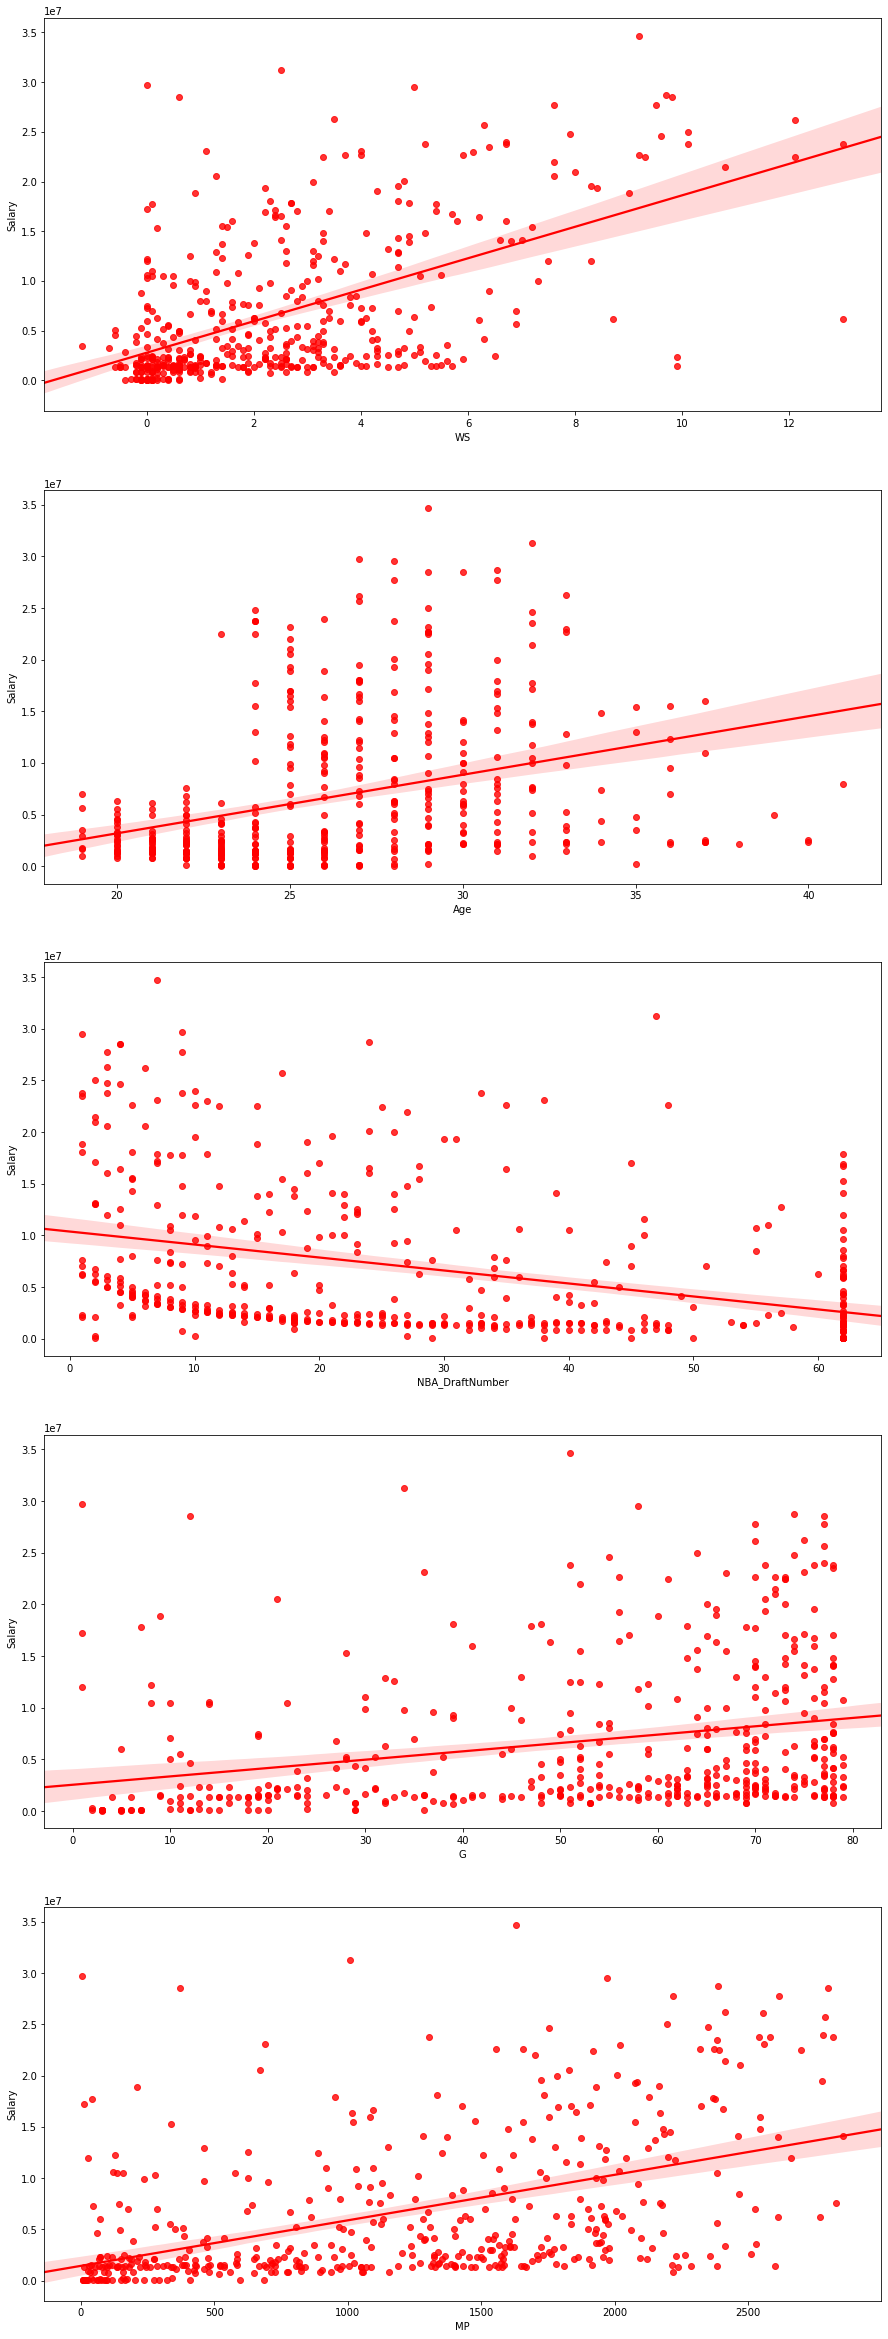

In [38]:
fig = plt.figure(figsize=(15,42))

plt.subplot(5,1,1)
#plt.figure(figsize=(10,6))
ax=sn.regplot(x='WS',y='Salary',data=data,color="Red")

plt.subplot(5,1,2)
#plt.figure(figsize=(10,6))
ax=sn.regplot(x='Age',y='Salary',data=data,color="Red")

plt.subplot(5,1,3)
#plt.figure(figsize=(10,6))
ax=sn.regplot(x='NBA_DraftNumber',y='Salary',data=data,color="Red")

plt.subplot(5,1,4)
#plt.figure(figsize=(10,6))
ax=sn.regplot(x='G',y='Salary',data=data,color="Red")

plt.subplot(5,1,5)
#plt.figure(figsize=(10,6))
ax=sn.regplot(x='MP',y='Salary',data=data,color="Red")

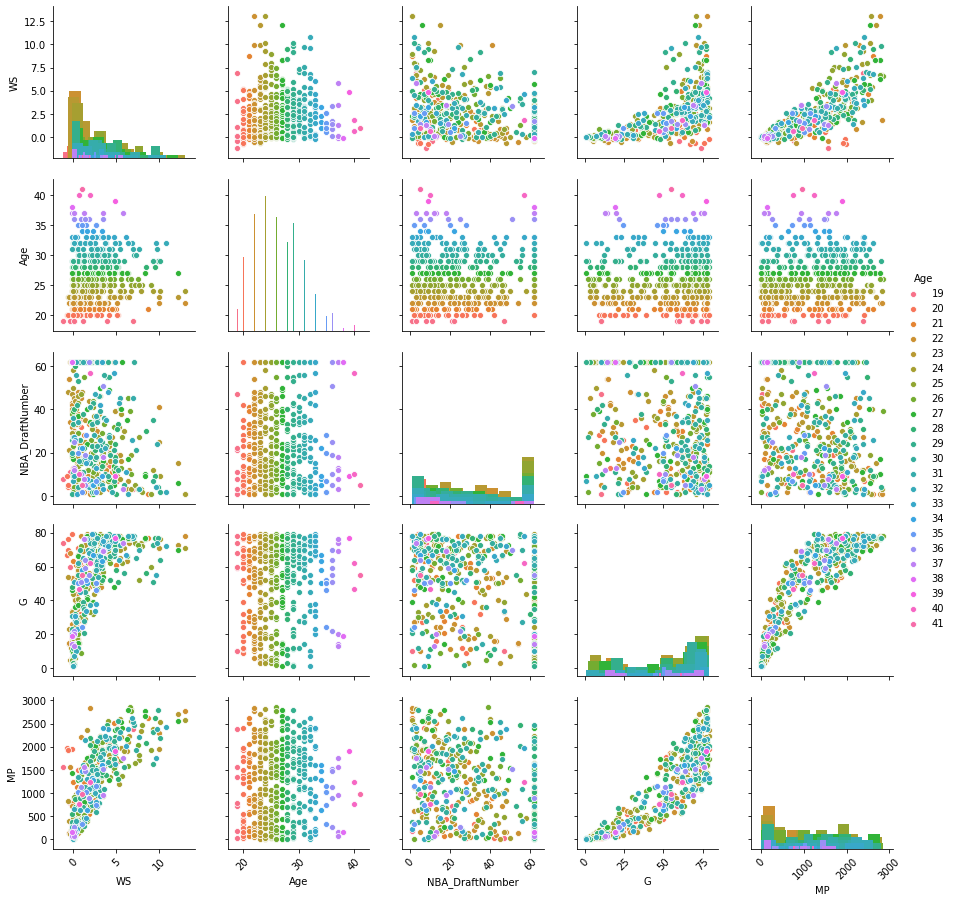

In [39]:
data_copy = data[['WS', 'Age', 'NBA_DraftNumber', 'G', 'MP']]
graph = sn.pairplot(data_copy,hue='Age',diag_kind="hist")
for ax in graph.axes.flat:
    plt.setp(ax.get_xticklabels(),rotation=45)

En la anterior gráfica se puede observar la relación que tiene la variable Salary con la el set de variables que tienen más correlación con este. Esto quiere decir que la afirmación que se hace en el gráfico de Correlación es correcta.  Además que después de aplicar el algoritmo  stepwise_selection se puede observar que la variable Age sigue siendo parte de las variables que tienen un efecto estrecho para la predicción de la variable Salary

# Protocolo de entrenamiento y evaluación de modelos Hold-out


Se optó por utilizar este protocolo ya que este método consiste en separar los datos en dos conjuntos, uno para el entrenamiento de los modelos y el otro para las pruebas, lo que permite entrenar y evaluar sin necesidad de conseguir más datos. Adicionalmente, nos permite ajustar los hiperparámetros de los modelos a apartir de los datos de prueba.

In [40]:
y=data[['Salary']]
X=data[['WS','Age','NBA_DraftNumber','G','MP']]

In [41]:
#spliting data into training and testing sets.
X_train,X_test,y_train,y_test= train_test_split(X,y, test_size=0.2,random_state=40)

# Entrenamineto de los modelos

### Regresión Lineal Multiple

In [42]:
reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [43]:
train_y_pred = reg.predict(X_train)
test_y_pred = reg.predict(X_test)
print(train_y_pred.shape)
print(test_y_pred.shape)

(372, 1)
(93, 1)


In [44]:
print("MSE (train): %.4f" % mean_squared_error(y_train, train_y_pred))
print("MSE (test) : %.4f" % mean_squared_error(y_test, test_y_pred))
print("RMSE (train): %.4f" % sqrt(mean_squared_error(y_train, train_y_pred)))
print("RMSE (test) : %.4f" % sqrt(mean_squared_error(y_test, test_y_pred)))
print("MAE (train): %.4f" % mean_absolute_error(y_train, train_y_pred))
print("MAE (test) : %.4f" % mean_absolute_error(y_test, test_y_pred))
print('R2  (train): %.4f' % r2_score(y_train, train_y_pred))
print('R2  (test) : %.4f' % r2_score(y_test, test_y_pred))

MSE (train): 26699241373626.5742
MSE (test) : 23973734576611.1445
RMSE (train): 5167130.8648
RMSE (test) : 4896298.0482
MAE (train): 3877198.3877
MAE (test) : 3766857.8880
R2  (train): 0.5043
R2  (test) : 0.5195


In [45]:
r2_aj_train = 1 - (1-r2_score(y_train, train_y_pred))*(len(y_train)-1) / (len(y_train) - X_train.shape[1] - 1)
print('R2 adj (train): %.4f' %r2_aj_train)
r2_aj_test = 1 - (1-r2_score(y_test, test_y_pred))*(len(y_test)-1) / (len(y_test) - X_test.shape[1] - 1)
print('R2 adj (test): %.4f' %r2_aj_test)

R2 adj (train): 0.4975
R2 adj (test): 0.4919


### KNN Regressor

In [46]:
training_KNN = []
test_KNN = []
k_num = range(2,100)

In [47]:
for num in k_num:
    knnR = KNeighborsRegressor(n_neighbors=num)
    knnR.fit(X_train, y_train)
    training_KNN.append(knnR.score(X_train, y_train))
    test_KNN.append(knnR.score(X_test, y_test))

Text(0, 0.5, 'Score')

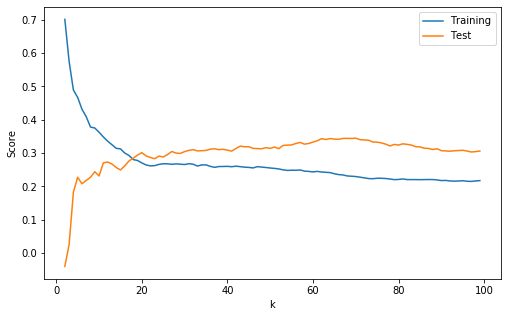

In [48]:
fig = plt.figure(figsize=(18,5))
fig.add_subplot(1, 2, 2)
grafico = plt.gca()
plt.plot(k_num, training_KNN)
plt.plot(k_num, test_KNN)
grafico.set_xlim(grafico.get_xlim()[::1])  
plt.legend(['Training', 'Test'])
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('Score')

In [49]:
best_k = k_num[np.argmax(test_KNN)]
best_s = max(test_KNN)

print("Mejor numero de vecinos:",best_k)
print("Mejor score:",best_s)

Mejor numero de vecinos: 70
Mejor score: 0.3447041932121273


In [50]:
knnR = KNeighborsRegressor(n_neighbors=best_k)
knnR.fit(X_train, y_train)
train_y_pred = knnR.predict(X_train)
test_y_pred = knnR.predict(X_test)

print("MSE (train): %.4f" % mean_squared_error(y_train, train_y_pred))
print("MSE (test) : %.4f" % mean_squared_error(y_test, test_y_pred))
print("RMSE (train): %.4f" % sqrt(mean_squared_error(y_train, train_y_pred)))
print("RMSE (test) : %.4f" % sqrt(mean_squared_error(y_test, test_y_pred)))
print("MAE (train): %.4f" % mean_absolute_error(y_train, train_y_pred))
print("MAE (test) : %.4f" % mean_absolute_error(y_test, test_y_pred))
print('R2  (train): %.4f' % r2_score(y_train, train_y_pred))
print('R2  (test) : %.4f' % r2_score(y_test, test_y_pred))

MSE (train): 41504121279033.9609
MSE (test) : 32693019717040.6133
RMSE (train): 6442369.2287
RMSE (test) : 5717781.0134
MAE (train): 4866960.4801
MAE (test) : 4501601.2192
R2  (train): 0.2294
R2  (test) : 0.3447


### Red Neuronal

In [51]:
warnings.filterwarnings("ignore")
max_iter_vec = [100, 300, 500, 800, 1000, 1500, 2000, 2500, 3000, 4000]
hidden_layer_sizes_vec = [(10, 10), (20, 20), (30, 30), (20, 10), (30, 20, 10), (30, 30, 30),(60, 90, 30),(80, 90, 80)]
learning_rate_init_vec = [0.001,0.002,0.003,0.005,0.005,0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05]

In [52]:
for k in max_iter_vec:
    mlp = MLPRegressor(solver='adam',alpha=1e-4,hidden_layer_sizes=(30,30,30), max_iter=k,learning_rate_init=0.003 , random_state=1)
    mlp.fit(X_train,y_train)
    predict_test = mlp.predict(X_test)
    print(k,'R2: %.4f' % (r2_score(y_test,predict_test)))

100 R2: 0.3006
300 R2: 0.2975
500 R2: 0.2975
800 R2: 0.2975
1000 R2: 0.2975
1500 R2: 0.2975
2000 R2: 0.2975
2500 R2: 0.2975
3000 R2: 0.2975
4000 R2: 0.2975


In [53]:
for k in hidden_layer_sizes_vec:
    mlp = MLPRegressor(solver='adam',alpha=1e-4,hidden_layer_sizes=k, max_iter=2000,learning_rate_init=0.003 , random_state=1)
    mlp.fit(X_train,y_train)
    predict_test = mlp.predict(X_test)
    print(k,'R2: %.4f' % (r2_score(y_test,predict_test)))

(10, 10) R2: 0.3168
(20, 20) R2: 0.3391
(30, 30) R2: 0.3601
(20, 10) R2: 0.3290
(30, 20, 10) R2: 0.5181
(30, 30, 30) R2: 0.2975
(60, 90, 30) R2: 0.3000
(80, 90, 80) R2: 0.4903


In [54]:
for k in learning_rate_init_vec:
    mlp = MLPRegressor(solver='adam',alpha=1e-4,hidden_layer_sizes=(80, 90, 80), max_iter=2000 ,learning_rate_init=k, random_state=1)
    mlp.fit(X_train,y_train)
    predict_test = mlp.predict(X_test)
    print(k,'R2: %.4f' % (r2_score(y_test,predict_test)))

0.001 R2: 0.4868
0.002 R2: 0.4932
0.003 R2: 0.4903
0.005 R2: 0.3015
0.005 R2: 0.3015
0.006 R2: 0.5136
0.007 R2: 0.5169
0.008 R2: 0.5203
0.009 R2: 0.3108
0.01 R2: 0.5050
0.02 R2: 0.4840
0.03 R2: 0.4780
0.04 R2: 0.2979
0.05 R2: 0.5106


In [55]:
mlp = MLPRegressor(solver='adam',alpha=1e-4,hidden_layer_sizes=(80, 90, 80), max_iter=2000 ,learning_rate_init=0.008, random_state=1)
mlp.fit(X_train, y_train)
train_y_pred = mlp.predict(X_train)
test_y_pred = mlp.predict(X_test)

print("MSE (train): %.4f" % mean_squared_error(y_train, train_y_pred))
print("MSE (test) : %.4f" % mean_squared_error(y_test, test_y_pred))
print("RMSE (train): %.4f" % sqrt(mean_squared_error(y_train, train_y_pred)))
print("RMSE (test) : %.4f" % sqrt(mean_squared_error(y_test, test_y_pred)))
print("MAE (train): %.4f" % mean_absolute_error(y_train, train_y_pred))
print("MAE (test) : %.4f" % mean_absolute_error(y_test, test_y_pred))
print('R2  (train): %.4f' % r2_score(y_train, train_y_pred))
print('R2  (test) : %.4f' % r2_score(y_test, test_y_pred))

MSE (train): 26045503198708.6133
MSE (test) : 23932878864364.5977
RMSE (train): 5103479.5188
RMSE (test) : 4892124.1669
MAE (train): 3687151.1650
MAE (test) : 3564514.0774
R2  (train): 0.5164
R2  (test) : 0.5203


# Transformación de datos PCA

Hasta el momento sabemos que el dataset cuenta con 24 variables, por lo que es necesario reducir este número para facilitar el análisis y visualización de los datos, por esta razón se hace uso de la transformación por PCA (Principal Componente Analysis) el cual tiene como objetivo generar nuevas variables no correlacionadas con las cuales podemos identificar cuales describen mejor el conjunto de datos.
Adicionalmente, se utilizaran los datos normalizados debido a que la técnica PCA se ve afectada por la distancia de los datos y tampoco no se tendrá en cuenta la columna del "Salary" ya que no nos interesa.

In [56]:
x_feactures = data[['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']]
x_fstandar = StandardScaler().fit_transform(x_feactures)
pca = PCA(n_components=0.95)
pComponents = pca.fit_transform(x_fstandar)
pComponents.shape

(465, 12)

La cantidad de componentes principales que representan en un 95% los datos son 12.

In [57]:
var_exp=pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

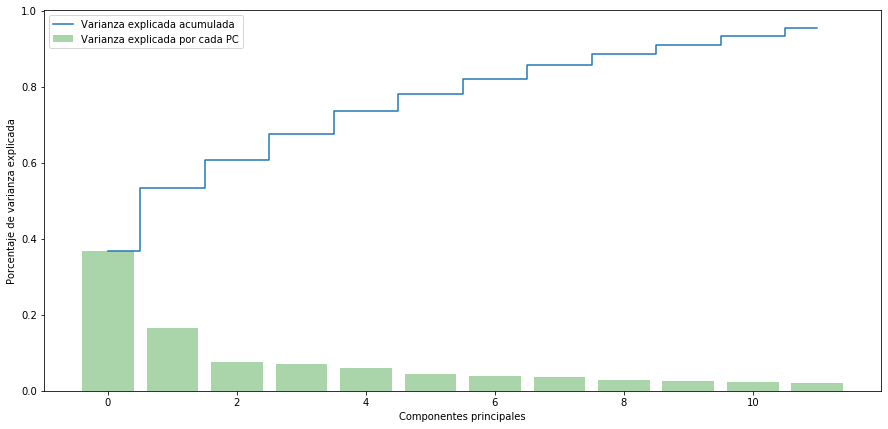

In [58]:
plt.figure(figsize=(15, 7))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='Varianza explicada por cada PC', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.show()

Se procede a analizar el significado de los componentes principales PCs, en donde por cada uno se identificaran las variables que tengan mayor relevancia.

In [145]:
def biplot(data, loadings, index1, index2, labels=None):
    plt.figure(figsize=(15, 7))
    xs = data[:,index1]
    ys = data[:,index2]
    n=loadings.shape[0]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, loadings[i,index1], loadings[i,index2],color='r',alpha=0.5)
        if labels is None:
            plt.text(loadings[i,index1]* 1.15, loadings[i,index2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(loadings[i,index1]* 1.15, loadings[i,index2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(index1+1))
    plt.ylabel("PC{}".format(index2+1))
    plt.grid() 

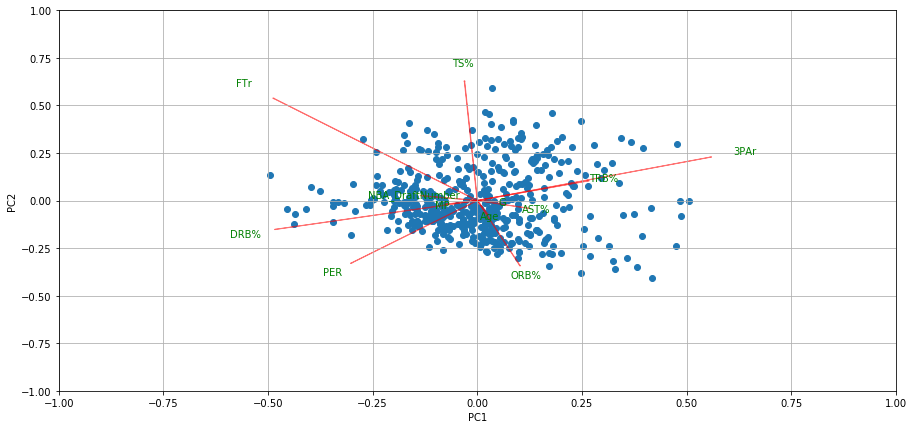

In [146]:
biplot(pComponents, pca.components_, 0, 1, ['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'])

### PC 1

Representación positiva:
- 3PAr
- TRB%

Representación negativa:
- PER
- DRB%
- FTr

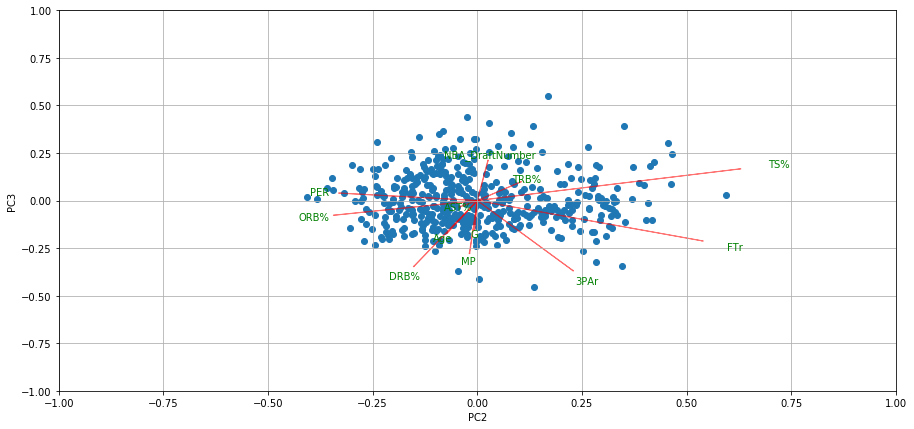

In [149]:
biplot(pComponents, pca.components_, 1, 2, ['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'])

### PC2

Representación positiva:
- FTr
- TS%

Representación negativa:
- ORB%
- PER

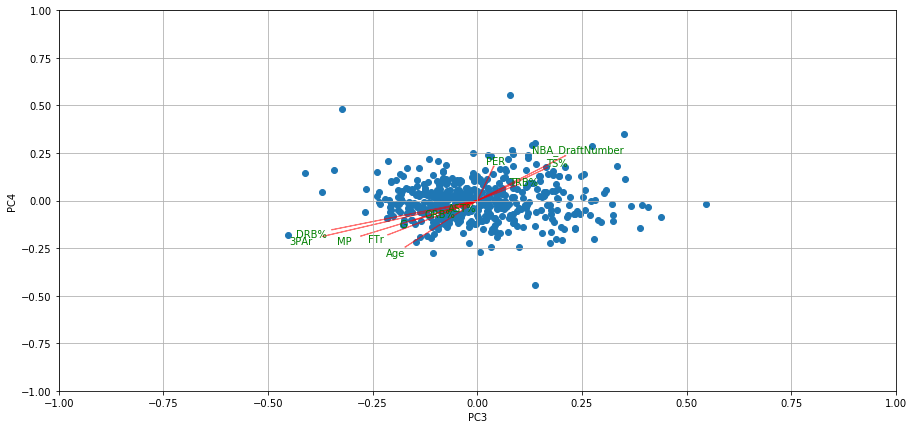

In [150]:
biplot(pComponents, pca.components_, 2, 3, ['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'])

### PC3

Representación negativa:
- 3PAr
- DRB%
- MP

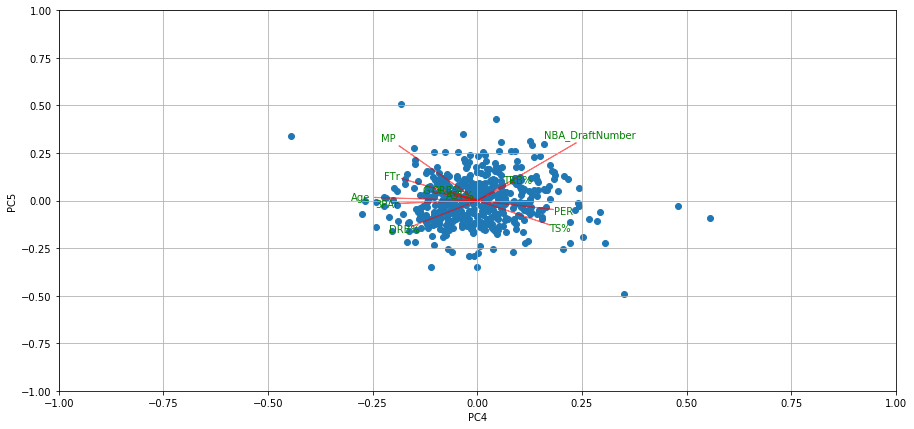

In [151]:
biplot(pComponents, pca.components_, 3, 4, ['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'])

### PC4

Representación negativa:
- Age

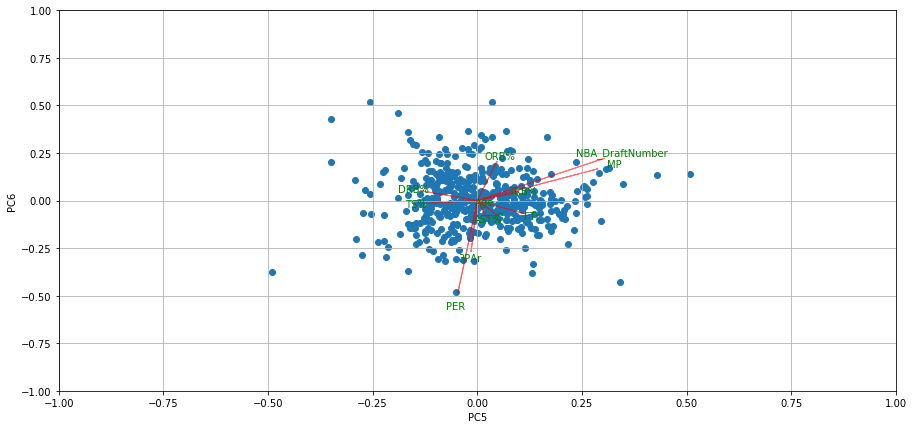

In [152]:
biplot(pComponents, pca.components_, 4, 5, ['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'])

### PC5

Representación positiva:
- NBA_DraftNumber
- MP

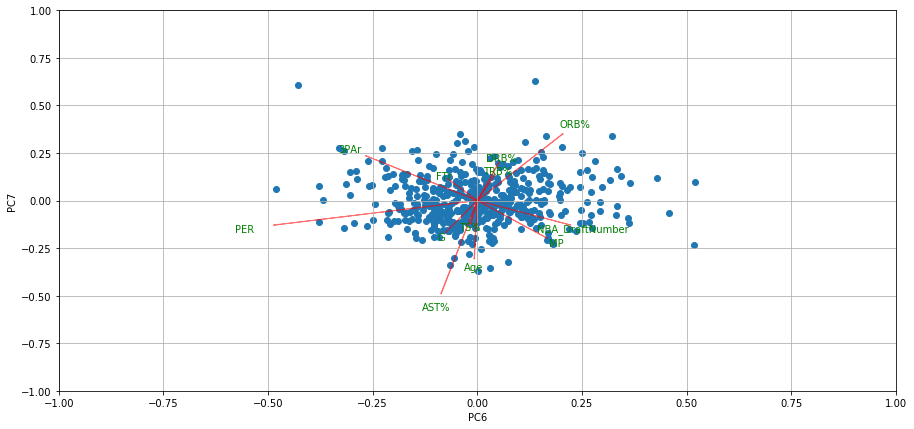

In [160]:
biplot(pComponents, pca.components_, 5, 6, ['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'])

### PC6

Representación negativa:
- PER
- 3PAr

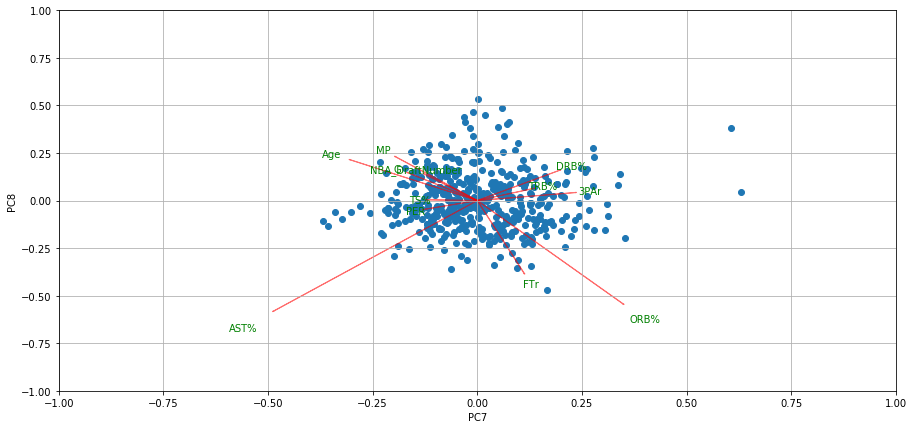

In [154]:
biplot(pComponents, pca.components_, 6, 7, ['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'])

### PC7

Representación positiva:
- ORB%

Representación negativa:
- Age
- AST%

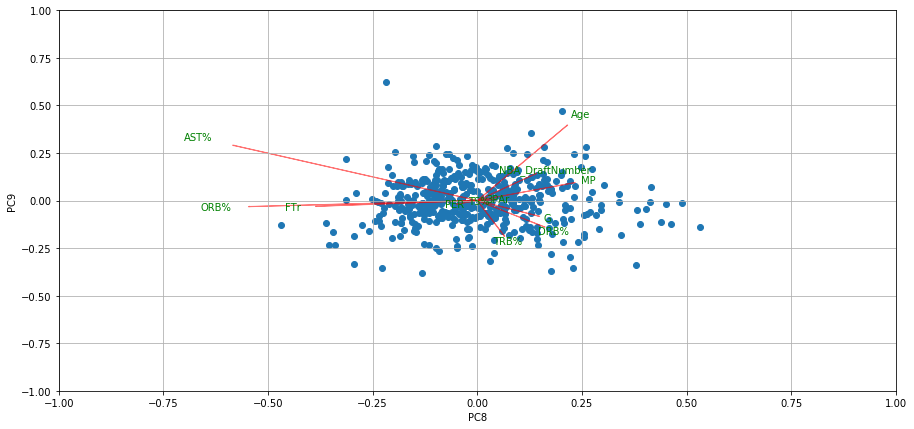

In [155]:
biplot(pComponents, pca.components_, 7, 8, ['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'])

### PC8

Representación negativa:
- AST%
- ORB%
- FTr

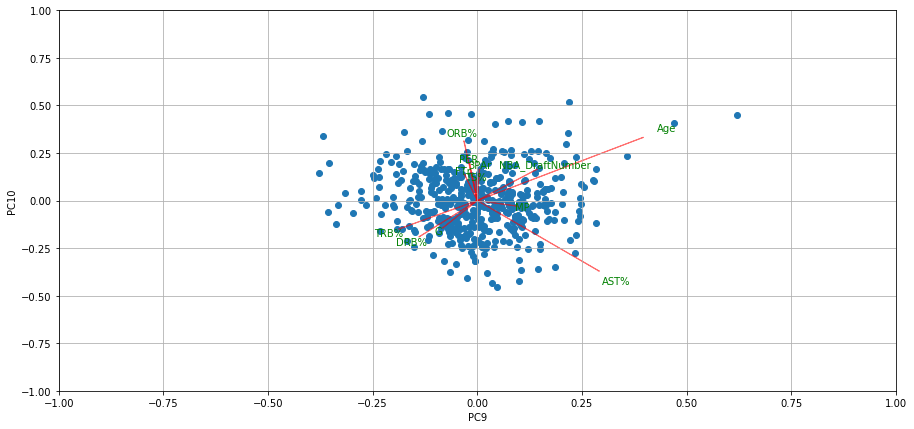

In [156]:
biplot(pComponents, pca.components_, 8, 9, ['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'])

### PC9

Representación positiva:
- Age
- AST%

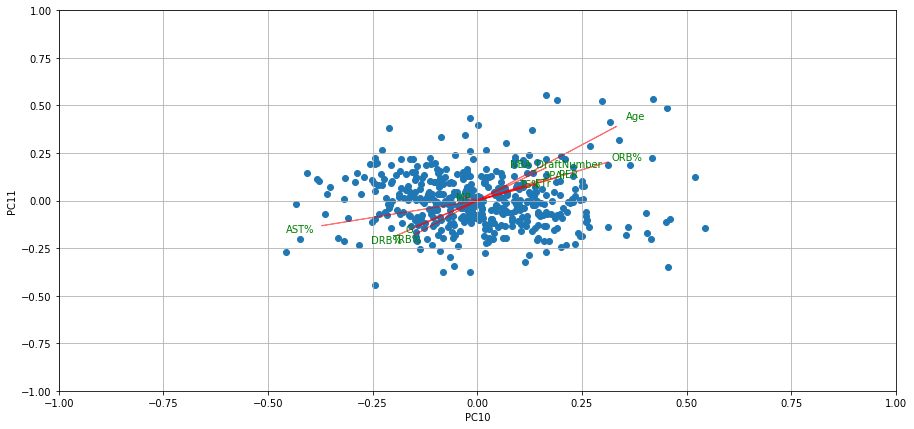

In [157]:
biplot(pComponents, pca.components_, 9, 10, ['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'])

### PC10

Representación positiva:
- Age
- ORB%

Representación negativa:
- AST%

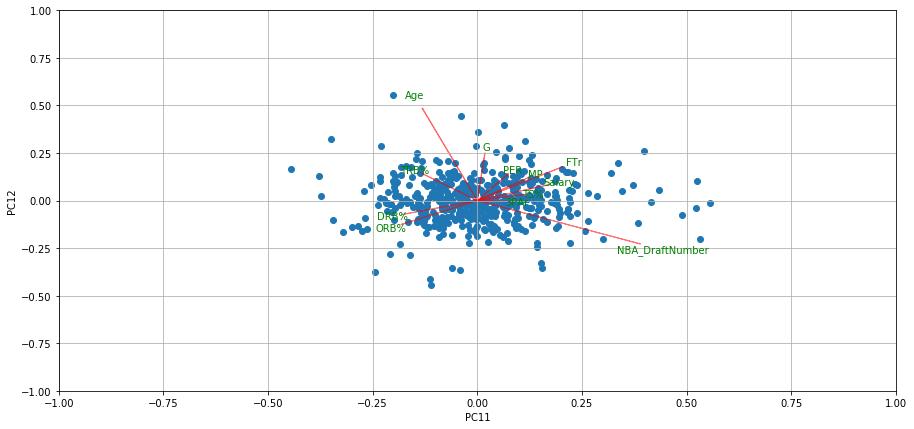

In [168]:
biplot(pComponents, pca.components_, 10, 11, ['Salary','NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'])

### PC11

Representación positiva:
- Age

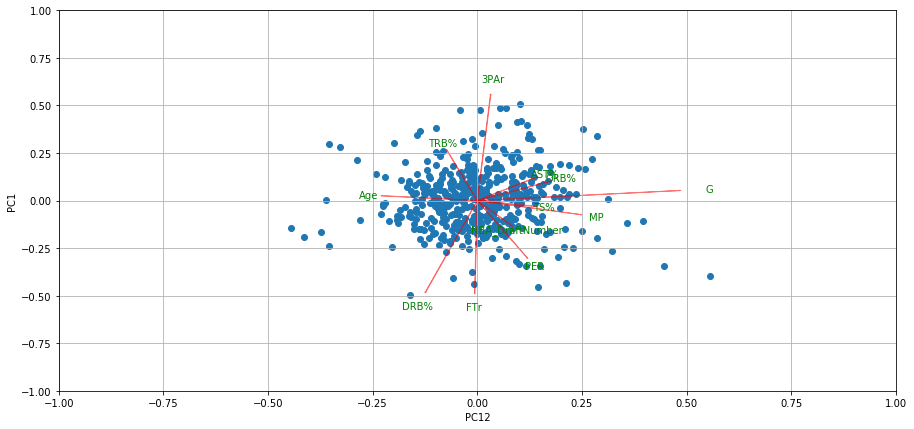

In [163]:
biplot(pComponents, pca.components_, 11, 0, ['NBA_DraftNumber','Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'])

### PC12

Representación positiva:
- G

# Selección del  mejor K 

Para llevar a cabo una buena selección del mejor K, se decidio realizar la ejecución de los métodos de Codo, Siluetas y Calinski-Harabasz, utilizando los datos del PCA y Salary.

In [59]:
x_f = pComponents+ (StandardScaler().fit_transform(data[['Salary']]))

### Codo

In [60]:
wcss = []

for i in range (1,11):
    kmeans = KMeans (n_clusters = i, max_iter=300)
    kmeans.fit(x_f)
    wcss.append(kmeans.inertia_)

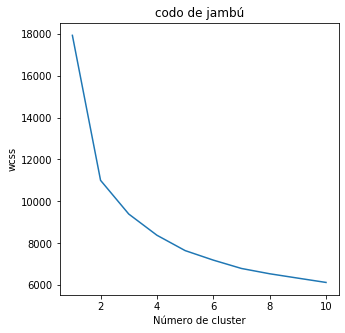

In [61]:
plt.figure(figsize=(5,5))
plt.plot(range(1,11),wcss)
plt.title('codo de jambú')
plt.xlabel('Número de cluster')
plt.ylabel('wcss')
plt.show()

Según la gráfica generada, no podemos identificar de manera precisa cual es le número optimo de Ks.

### Siluetas

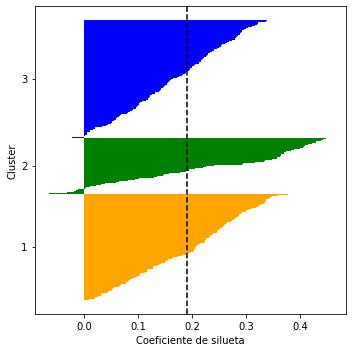

In [62]:
plt.figure(figsize=(5,5))
k=3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(x_f)
y_clusters = kmeans.labels_
cluster_labels = np.unique(y_clusters)

silueta_puntos= silhouette_samples(x_f, y_clusters, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
colores = ['orange','green','blue','cyan','magenta','black']
for i, c in enumerate(cluster_labels):
    silueta_puntos_c = silueta_puntos[y_clusters == c]
    silueta_puntos_c.sort()
    y_ax_upper += len(silueta_puntos_c)
    color = colores[i]
    plt.barh(range(y_ax_lower, y_ax_upper), silueta_puntos_c, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(silueta_puntos_c)


silueta_promedio = np.mean(silueta_puntos)
plt.axvline(silueta_promedio, color="black", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Coeficiente de silueta')

plt.tight_layout()

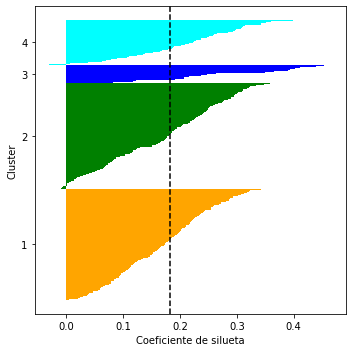

In [63]:
plt.figure(figsize=(5,5))
k=4
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(x_f)
y_clusters = kmeans.labels_
cluster_labels = np.unique(y_clusters)

silueta_puntos= silhouette_samples(x_f, y_clusters, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
colores = ['orange','green','blue','cyan','magenta','black']
for i, c in enumerate(cluster_labels):
    silueta_puntos_c = silueta_puntos[y_clusters == c]
    silueta_puntos_c.sort()
    y_ax_upper += len(silueta_puntos_c)
    color = colores[i]
    plt.barh(range(y_ax_lower, y_ax_upper), silueta_puntos_c, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(silueta_puntos_c)


silueta_promedio = np.mean(silueta_puntos)
plt.axvline(silueta_promedio, color="black", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Coeficiente de silueta')

plt.tight_layout()

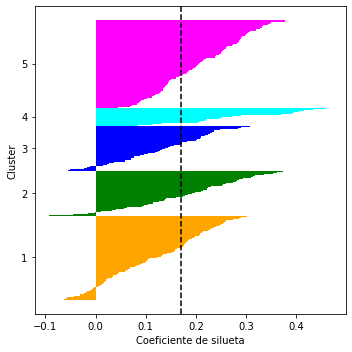

In [64]:
plt.figure(figsize=(5,5))
k=5
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(x_f)
y_clusters = kmeans.labels_
cluster_labels = np.unique(y_clusters)

silueta_puntos= silhouette_samples(x_f, y_clusters, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
colores = ['orange','green','blue','cyan','magenta','black']
for i, c in enumerate(cluster_labels):
    silueta_puntos_c = silueta_puntos[y_clusters == c]
    silueta_puntos_c.sort()
    y_ax_upper += len(silueta_puntos_c)
    color = colores[i]
    plt.barh(range(y_ax_lower, y_ax_upper), silueta_puntos_c, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(silueta_puntos_c)


silueta_promedio = np.mean(silueta_puntos)
plt.axvline(silueta_promedio, color="black", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Coeficiente de silueta')

plt.tight_layout()

### Calinski-Harabasz

In [76]:

kmeans_model = KMeans(n_clusters=3, random_state=1).fit(x_f)
labels = kmeans_model.labels_
metrics.calinski_harabasz_score(x_f, labels)

209.4422380394664

In [70]:
kmeans_model = KMeans(n_clusters=4, random_state=1).fit(x_f)
labels = kmeans_model.labels_
metrics.calinski_harabasz_score(x_f, labels)

174.5779774886617

In [71]:
kmeans_model = KMeans(n_clusters=5, random_state=1).fit(x_f)
labels = kmeans_model.labels_
metrics.calinski_harabasz_score(x_f, labels)

154.1892761952962

Luego de realizar un análisis sobre las siluetas con k igual a 3, 4 y 5, logramos determinar que el mejor K es 3, debido a que en una primera instancia todas las siluetas pasan el promedio y por otro lado, los valores negativos del coheficiente para cada una de las siluetas es bajo en comparación con las demás gráficas. Adicionalmente, con el algoritmo de Calinski-Harabasz con un K igual a 3 encontramos el mejor score.

# Caracterización de perfiles

### KMeans

In [79]:
dataPCA = pd.DataFrame(pComponents)
dataPCA= dataPCA.iloc[:, 0:4]
dataPCA.columns=['PC1', 'PC2', 'PC3','PC4']
dataPCA.head()

,PC1,PC2,PC3,PC4
0,-5.014368,3.711257,0.188431,-1.234174
1,2.371605,2.381025,0.833592,0.207489
2,0.392613,0.289556,-0.356532,1.215340
3,-1.529636,-0.732235,0.799138,2.193889
4,-1.461766,1.257720,-0.632700,-1.201827


In [81]:
clustering = KMeans(n_clusters=3, max_iter = 300 )
clustering.fit(dataPCA)
clusters = clustering.labels_

In [82]:
dataPCA['Cluster']= clusters

,PC1,PC2,PC3,PC4,Cluster
0,-5.014368,3.711257,0.188431,-1.234174,2
1,2.371605,2.381025,0.833592,0.207489,0
2,0.392613,0.289556,-0.356532,1.215340,1
3,-1.529636,-0.732235,0.799138,2.193889,2
4,-1.461766,1.257720,-0.632700,-1.201827,2


In [119]:
x_f = dataPCA+ (StandardScaler().fit_transform(data[['Salary']]))

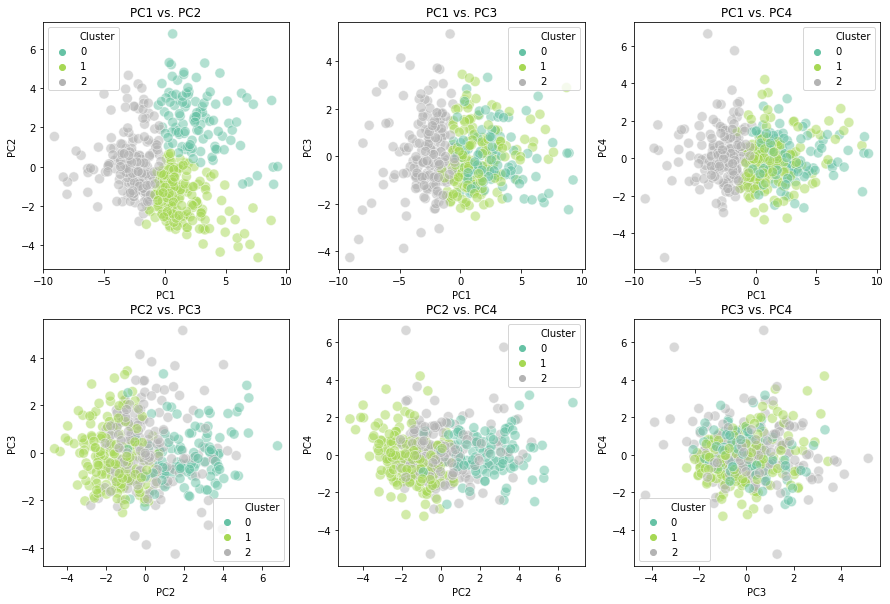

In [114]:
fig = plt.figure(figsize=(15,10))
colorPalette = "Set2"
ax = fig.add_subplot(2, 3, 1)
sn.scatterplot(x="PC1", y="PC2", hue="Cluster", data=dataPCA, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC1 vs. PC2")

ax = fig.add_subplot(2, 3, 2)
sn.scatterplot(x="PC1", y="PC3", hue="Cluster", data=dataPCA, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC1 vs. PC3")

ax = fig.add_subplot(2, 3, 3)
sn.scatterplot(x="PC1", y="PC4", hue="Cluster", data=dataPCA, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC1 vs. PC4")

ax = fig.add_subplot(2, 3, 4)
sn.scatterplot(x="PC2", y="PC3", hue="Cluster", data=dataPCA, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC2 vs. PC3")

ax = fig.add_subplot(2, 3, 5)
sn.scatterplot(x="PC2", y="PC4", hue="Cluster", data=dataPCA, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC2 vs. PC4")

ax = fig.add_subplot(2, 3, 6)
sn.scatterplot(x="PC3", y="PC4", hue="Cluster", data=dataPCA, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC3 vs. PC4")


plt.show()

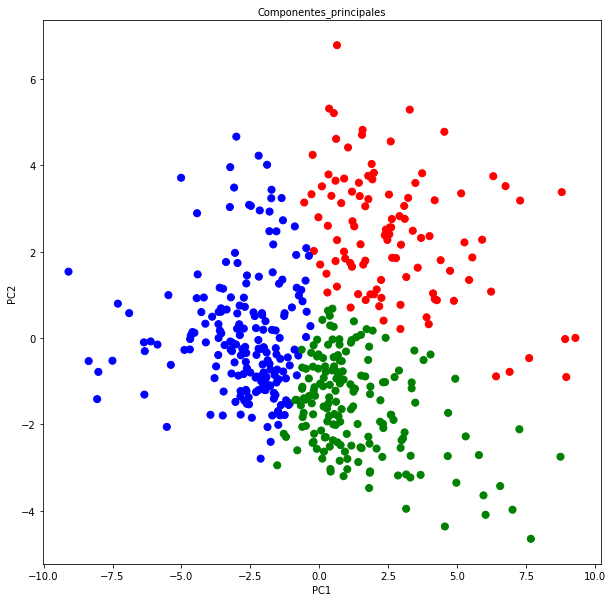

In [116]:
    fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1', fontsize=10)
ax.set_ylabel('PC2', fontsize=10)
ax.set_title('Componentes_principales', fontsize=10)

color_theme= np.array(['red','green','blue','cyan','magenta','black'])

ax.scatter(x=dataPCA.PC1, y=dataPCA.PC2, c= color_theme[dataPCA.Cluster] ,s=50)
plt.show()

Luego de realizar un análisis sobre las anteriores gráficas, logramos identificar que PC1 vs PC2 separa mejor los clusters debido a que se diferencian facilmente los grupos y no se sobreponen los puntos.

### Cluster Jerarquico

Text(0.5, 1.0, 'single linkage')

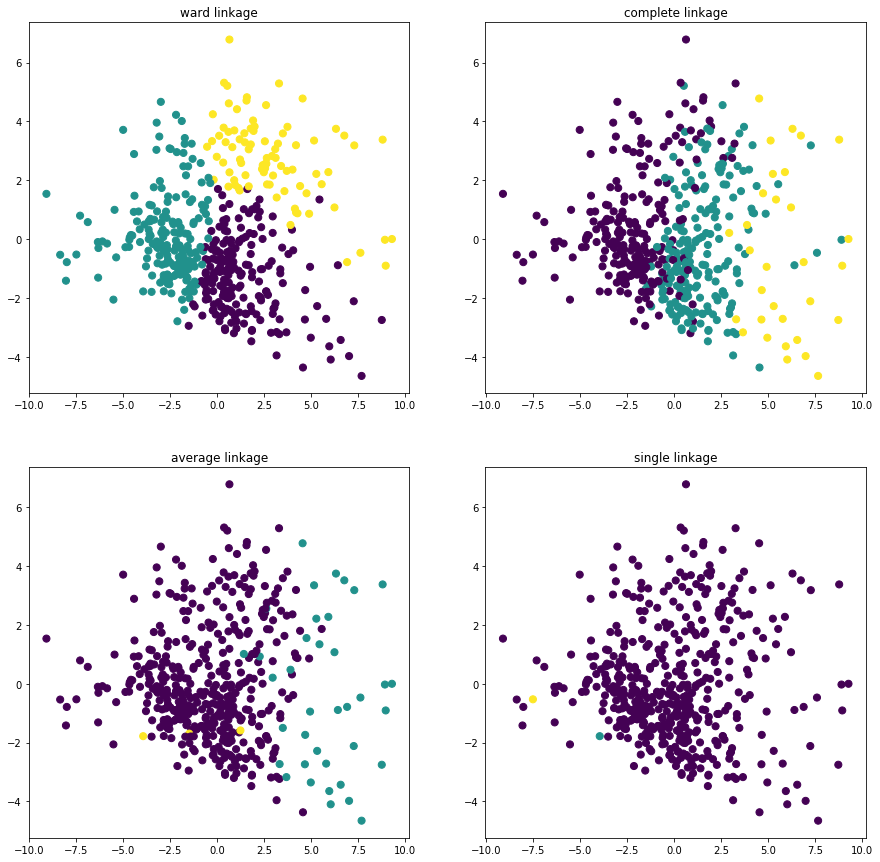

In [120]:
fig, axes = plt.subplots(2,2,figsize=(15,15))

link = 'ward'
clustering = AgglomerativeClustering(linkage=link, n_clusters=3)
clustering.fit(dataPCA)
axes[0][0].scatter(dataPCA.PC1,dataPCA.PC2, c=clustering.labels_, s=50, cmap='viridis')
axes[0][0].set_title("%s linkage" % link)

link = 'complete'
clustering = AgglomerativeClustering(linkage=link, n_clusters=3)
clustering.fit(x_f)
axes[0][1].scatter(dataPCA.PC1,dataPCA.PC2, c=clustering.labels_, s=50, cmap='viridis')
axes[0][1].set_title("%s linkage" % link)

link = 'average'
clustering = AgglomerativeClustering(linkage=link, n_clusters=3)
clustering.fit(x_f)
axes[1][0].scatter(dataPCA.PC1,dataPCA.PC2, c=clustering.labels_, s=50, cmap='viridis')
axes[1][0].set_title("%s linkage" % link)

link = 'single'
clustering = AgglomerativeClustering(linkage=link, n_clusters=3)
clustering.fit(x_f)
axes[1][1].scatter(dataPCA.PC1,dataPCA.PC2, c=clustering.labels_, s=50, cmap='viridis')
axes[1][1].set_title("%s linkage" % link)

In [121]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')

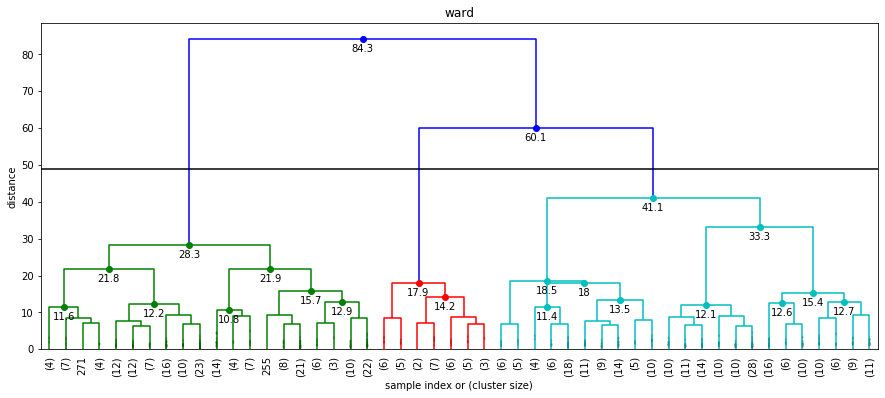

In [122]:
fig, axes = plt.subplots(figsize=(15,6))
link = 'ward'
fusiones = linkage(x_f, link)
fancy_dendrogram(
    fusiones,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=49,  # plot a horizontal cut-off line
)
plt.title(link)
plt.show()

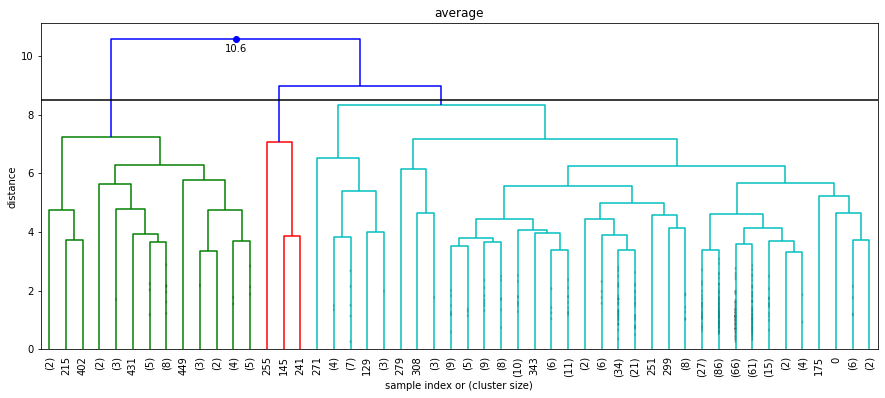

In [126]:
fig, axes = plt.subplots(figsize=(15,6))
link = 'average'
fusiones = linkage(x_f, link)
fancy_dendrogram(
    fusiones,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=8.5,  # plot a horizontal cut-off line
)
plt.title(link)
plt.show()

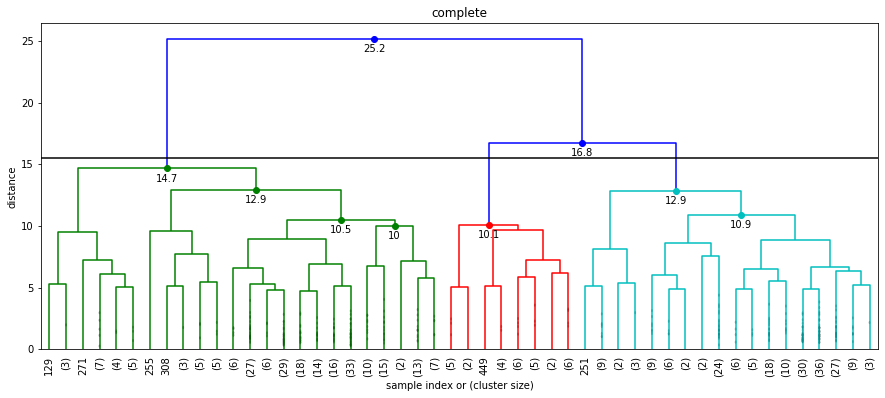

In [127]:
fig, axes = plt.subplots(figsize=(15,6))
link = 'complete'
fusiones = linkage(x_f, link)
fancy_dendrogram(
    fusiones,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=15.5,  # plot a horizontal cut-off line
)
plt.title(link)
plt.show()

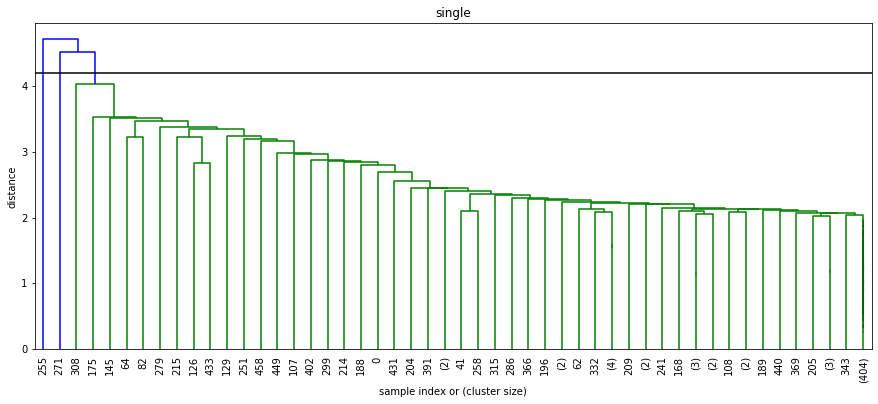

In [128]:
fig, axes = plt.subplots(figsize=(15,6))
link = 'single'
fusiones = linkage(x_f, link)
fancy_dendrogram(
    fusiones,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=4.2,  # plot a horizontal cut-off line
)
plt.title(link)
plt.show()

Luego de análizar las distintas gráficas que brindan los métodos para hacer clustering (Kmeans y Jerarquico), logramos determinar que la mejor opción es Kmeans, debido a que representa una mejor separación de los grupos.

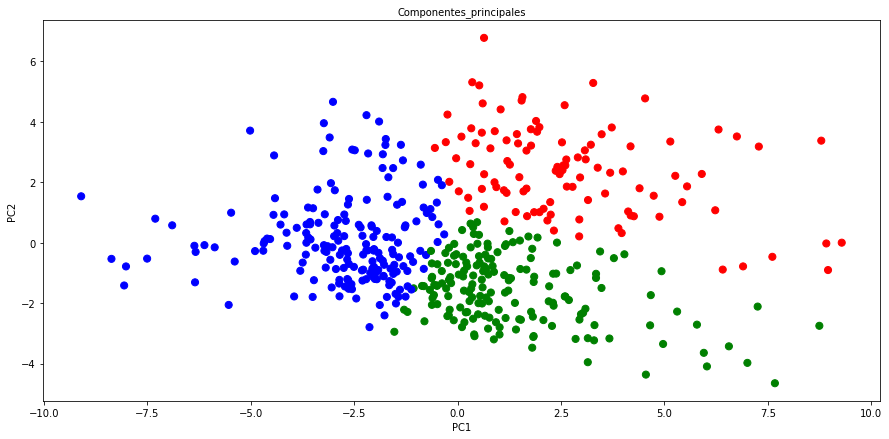

In [167]:
    fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1', fontsize=10)
ax.set_ylabel('PC2', fontsize=10)
ax.set_title('Componentes_principales', fontsize=10)

color_theme= np.array(['red','green','blue','cyan','magenta','black'])

ax.scatter(x=dataPCA.PC1, y=dataPCA.PC2, c= color_theme[dataPCA.Cluster] ,s=50)
plt.show()

Finalmente, teniendo en cuenta que el mejor cluster esta representado por PC1 VS PC2 podemos concluir:
    
En una primera instancia, sabemos que PC1 esta compuesto por 3PAr y TRB% en representación positiva y esta compuesto por FTr, DRB% Y PER en representación negativa, y por otro lado, sabemos que PC2 esta compuesto por FTr y TS% en representación positiva y esta compuesto por ORB% y PER en una representación negativa.  


PC1:
- 3PAr
- TRB%
- FTr
- DRB%
- PER

PC2:
- FTr
- TS%
- ORB%
- PER

Cluster Azul: En este cluster se evidencia que se encuentra un grupo de jugadores los cuales cuentan con alto nivel en las carácteristicas FTr, DRB% y PER. Para un mayor entendimiento, en este grupo se encuentran jugadores con una alta tasa de intentos de tiro libre, un buen porcentaje de rebotes defensivos y por último buena eficiencia en los partidos.

Cluester Rojo: En este cluester se evidencia que se encuentra un grupo de jugadores los cuales cuentan con alto nivel en las carácteristicas TRB% 3PAR Y TS%. Por un lado, en este grupo se encuentran jugadores quienes cuentan con un buen porcentaje de rebotes en los partidos. Por otro lado, cuentan con una buena tasa de intentos de tiros de tres puntos y finalmente presentan un buen porcentaje de tiros, una estadística que agrupa los números en dobles, triples y tiros libres, para definir cuán eficaz es cada protagonista.

Cluester Verde: En este cluester se evidencia que se encuentra un grupo de jugadores los cuales cuentan con alto nivel en la carácteristica ORB%, la cual representa un buen porcentaje en los rebotes ofensivos.





  